In [ ]:
#5.11 high way
# last modified 2024/4/24 
# %matplotlib ipympl
%matplotlib inline
import h5py 
import glob
from scipy import signal
import numpy as np
import matplotlib.pyplot as plt
from DasTools import DasPrep as dp
import os
import datetime
import matplotlib
import logging
import csv
import time
def concat(flist , start = 0 , span = 20 ):
    datalist = []

    for fname in flist[ start : min( start + span , len(flist) ) ]:
        data = dp.read_das(fname)
        datalist.append(data)

    
    data = np.concatenate(datalist, axis = 1)
    utc_datetime = datetime.datetime.strptime(flist[start][-22 : -7],'%Y%m%d_%H%M%S') + datetime.timedelta(hours=+8)
    utc_day = utc_datetime.strftime("%m-%d %H:%M")
    print("cat", data.shape)
    return data , utc_datetime, utc_day 


def psd(h5file , startn, endn , span_each_pic , dt , window ):
    with h5py.File(h5file, 'w') as f:
    # 创建一个dataset
        concat_time = 0
        ch_list = [i for i in range(2176)]
        for n in range(startn, endn , span_each_pic):
            data , utc_datetime, utc_day = concat(flist , start= n ,span= span_each_pic)
            fs = 1/dt
            data = dp.das_preprocess(data)
            nfft = window*fs
            start = time.time()
            for i in range(len(ch_list)):
                ch = ch_list[i]
                if not f.__contains__(str(ch_list[i])):   #判断这个组存不存在
                    g = f.create_group(str(ch_list[i]))
                else:
                    g = f[str(ch_list[i])]
                # g =  f.create_group(str(ch_list[i]))  
                [f1,Pxx1] = signal.welch(data[i],                   # 随机信号
                                nfft=nfft,               # 每个窗的长度
                                fs=fs,                   # 采样频率   
                                average='median' , 
                                # detrend='mean',          # 去掉均值
                                window=np.hanning(nfft), # 加汉尼窗
                                noverlap=int(nfft*3/4),  # 每个窗重叠75%的数据
                                )        # 求单边谱
                g.create_dataset(str(utc_day),  data=Pxx1, chunks = (3001) )
            concat_time +=  time.time() -start
            print(n , "拼接运行时间:%.2f min %d s"%( int(concat_time / 60) , concat_time%60) , datetime.datetime.now() , utc_day, "check in ")
        f.close()

flist = glob.glob('/mnt/f/Highway_2024_0510/test03_05_10/*.h5')
flist.sort()
print(len(flist))

path = '/mnt/f/Highway_2024_0510/output/psd_6_14/'
if not os.path.exists(path):
    os.makedirs(path)

# h5fname = path+ '/test03_05_10_1.hdf5'
# psd(h5fname , 0, 250 ,12 , dt= 0.001 , window=90 ) 

h5fname = path+ '/test03_05_10_1.hdf5'
psd(h5fname , 0, 250 , 4 , dt= 0.001 , window=6 ) 
# h5fname = '/mnt/f/Highway_2024_0510/output/psd_5_20_v0/test03_05_10_1.hdf5'
# psd(h5fname , 13, 25 ,10 , dt= 0.001 , window=30) #test03  14m17s / 8min 7s ---> 

# h5fname = '/mnt/f/Highway_2024_0510/output/psd_5_11_v3/test03_05_10_1.hdf5'
# psd(h5fname , 30, 62 ,4 , dt= 0.001 , window=6) #test03  14m17s / 8min 7s --->

#save file size = interval per chunk 

#当数据量比较小的时候要提高减少nfft 和span提高分辨率


In [ ]:
import os
import scipy
from DasTools import DasPrep as dp
import h5py
import glob
from scipy import signal
import numpy as np
import matplotlib.pyplot as plt
import os
import time

##########################################
def plot_sub_set(ax  , xsticks = [] , ysticks = []  , xlabel = '', ylabel = '', title = '', c = -1 , r = 1):
    fonts = 15
    if c > 0 :
        ax.set_yticks([])
    else:
        ax.set_yticks(ysticks[0],ysticks[1])
        ax.set_ylabel(ylabel,fontsize=fonts)
    ax.set_xticks([])
    if r < 0 :
        ax.set_xticks([0],[xsticks[0]*8], rotation=90)
    elif r == 2 and c%2 == 1 and c//2 > 0 :
        ax.set_xticks([0],[c//2])
    # ax.set_xlabel(xlabel,fontsize=fonts)
    ax.grid()
    # ax.set_title(title,fontsize=fonts)
    ax.tick_params(axis='x', labelsize=fonts-5)
    ax.tick_params(axis='y', labelsize=fonts-5)



def show_ifft_time_range_amtitude_channel_split(flist  , ch_list, frequencise ,  dis_spacing ,  title ,  
                                                save_path ,split , t_range = [0,-1] , 
                                                lp = 1 , hp = 200 ,
                                                w = 20,
                                                start_time = None , end_time = None ,psdfile = None  ):
    if not os.path.exists(save_path):
        os.makedirs(save_path)
    all_AC = []
    all_psd = []
    if psdfile is None:
        for ch in ch_list:
            for fi in flist:
                with h5py.File(fi, 'r') as f:
                    if len(f[str(ch)].keys()) == 1 :
                        dset = f[str(ch)]['01']
                    else:
                        dset = f[str(ch)]
                    time = [i for i in dset.keys()][t_range[0] : t_range[-1]]
                    
                    if start_time is not None and end_time is not None : 
                        time = time[time.index(start_time):time.index(end_time)+1]
                    psd = np.average([dset[ti] for ti in time] ,axis=0)
                    all_psd.append(psd)
                    AC = np.fft.ifft( np.abs(np.append(psd[::-1][:-2] , psd)))
                    f.close()
                    # AC = np.fft.fftshift(AC)
                    all_AC.append(np.abs(AC[: len(AC)//2]))


        with h5py.File(save_path+'acf' +'.hdf5', 'w') as f:
            f.create_dataset(str(time),  data=all_AC )
            f.close()
    else:
        with h5py.File(psdfile, 'r') as f:
            all_psd = np.array(f['psd'][ch_list[0] : ch_list[1], :])
            print(all_psd.shape)
            all_AC = np.abs(np.fft.ifft2(np.append(all_psd[::-1 , ] , all_psd ,axis= 1))[: , : len(all_psd[0])])
            time = ""
            print(all_AC.shape)

    all_AC = all_AC[:,:1001]
    all_psd=all_psd[:,:601]
    sum_psd = np.sum(all_psd,axis = 1)    
    balenced_psd =  np.divide(all_psd.T,sum_psd /70000).T
    print(balenced_psd.std() ,all_psd.std()) 
    all_AC = np.divide(all_AC.T , sum_psd /70000 ).T
    rolling_mean = np.array ([ np.convolve(ac, np.ones(w), "valid") / w for ac in all_AC] )
    deco = np.array([scipy.signal.deconvolve(all_AC[i] , rolling_mean[i])[1] for i in range(len(all_AC))])
    filter_data = dp.bandpass(deco, 0.001, lp , hp )
    title = "w = " + str(w) + " " + str(lp) + "-" + str(hp) + " Hz"
    # filter_data = dp.lowpass(deco, 0.001, 60 )

    fq_stick = [ np.linspace(0,len(all_psd[0]),11) ,np.linspace(0,frequencise//10,11) ]
    time_stick = [np.linspace(0,len(all_AC[0]) , 4) ,np.around( np.linspace(0, len(all_AC[0])/frequencise , 4 ) , 1) ]
    ch_stick = [range(0,len(all_psd),50) , range(ch_list[0], ch_list[1],50)]
    w_r = [ ]
    sp_ch_list= []
    start_ch = 0
    for i in split:
        w_r.append(  np.ceil((i - start_ch)/10))
        sp_ch_list.append([start_ch, i])
        start_ch = i
    
    print(w_r , sp_ch_list)
    fig, ax_list = plt.subplots(3, len(split), gridspec_kw={"width_ratios": w_r, "height_ratios": [1, 1, 1]} , figsize=(20, 12 ))

    filter_data_s = filter_data/np.max(filter_data) * 20

    ax_r1 , ax_r2 , ax_r3 = ax_list
    for c in range(len(split)):
        sp_ch = sp_ch_list[c]
        ax_r1[c].imshow(np.log(all_psd[sp_ch[0] : sp_ch[1]]).T, aspect='auto', cmap='jet', vmin=0, vmax=15)
        plot_sub_set(ax_r1[c],sp_ch , fq_stick , 'Channel sp = 8 m' , 'fq(Hz)' , "log(PSD)"+title + time , c)
        ax_r2[c].imshow(np.log(balenced_psd[sp_ch[0] : sp_ch[1]]).T, aspect='auto', cmap='jet', vmin=0, vmax=7)
        plot_sub_set(ax_r2[c],sp_ch , fq_stick , 'Channel sp = 8 m' , 'fq(Hz)' , "balance (PSD)"+title + time ,c , r = 2)
        ax_r3[c].imshow(filter_data_s[sp_ch[0] : sp_ch[1]].T, aspect='auto', cmap='gray', vmin=0, vmax=filter_data_s[sp_ch[0] : sp_ch[1]].std()/5)
        plot_sub_set(ax_r3[c],sp_ch , time_stick , 'Channel sp = 8 m' , 'Time (s)' , "10-100 Hz filter , w = "+str(w)+title + time,c , r = -1)
    # plt.tight_layout() 
    # plt.suptitle(title + " PSD -> Balanced -> AC")
    plt.savefig(save_path+time+title+str(ch_list))
    
    # plt.show()
    plt.close()

    for c in range(len(split)):
        sp_ch = sp_ch_list[c]
        plt.figure(figsize=[6,2])
        plt.imshow(filter_data_s[sp_ch[0] : sp_ch[1]].T, aspect='auto', cmap='gray', vmin=0, vmax=filter_data_s[sp_ch[0] : sp_ch[1]].std()/5)
        plt.yticks(time_stick[0] , time_stick[1])
        if c%2 == 1 and c//2 > 0 :
            plt.title("AC Bridge "+ str(c//2))
        elif c == 2:
            plt.title("AC Tunnel")

        else:
            plt.title("AC road after Bridge "+ str(c//2-1))
        plt.xticks([0 , sp_ch[1] - sp_ch[0] - 1 ] , [sp_ch[0]*8 , sp_ch[1]*8])
        plt.ylabel("Time (s)")
        plt.xlabel("Location (m)")
        plt.savefig(save_path+time+title+str(sp_ch))
        plt.show()
        plt.close()
        # plot_sub_set(ax_r3[c],sp_ch , time_stick , 'Channel sp = 8 m' , 'Time (s)' , "10-100 Hz filter , w = "+str(w)+title + time,c , r = -1)



mutation_stamp = [ 43, 131,  390,406, 427, 434,   470,     553, 587,    625,  679,  685,  745, 761, 770, 855, 865, 888, 930, 966, 1011,
                  1059, 1157, 1251,  1310, 1343,  1381, 1390, 1411, 1570, 1788, 1804, 1860, 1898, 1968, 2024 ,2175]
show_ifft_time_range_amtitude_channel_split(psdfile='/mnt/f/Highway_2024_0510/output/psd_5_11_v3/test03_05_10_all_psd.hdf5', 
                                            flist=[] , ch_list = [0,2176] , frequencise= 1000 , dis_spacing= 8 , title='high way   ' , 
                                            split=mutation_stamp,
                                            w = 200 , lp = 1 , hp = 100,
                                            save_path='/mnt/f/Highway_2024_0510/output/psd_5_11_v3/')



In [ ]:
import os
import scipy
from DasTools import DasPrep as dp
import h5py
import glob
from scipy import signal
import numpy as np
import matplotlib.pyplot as plt
import os
import time

##########################################
def plot_sub_set(ax  , xsticks = [] , ysticks = []  , xlabel = '', ylabel = '', title = '', c = -1 , r = 1):
    fonts = 15
    if c > 0 :
        ax.set_yticks([])
    else:
        ax.set_yticks(ysticks[0],ysticks[1])
        ax.set_ylabel(ylabel,fontsize=fonts)
    ax.set_xticks([])
    if r < 0 :
        ax.set_xticks([0],[xsticks[0]*8], rotation=90)
    elif r == 2 and c%2 == 1 and c//2 > 0 :
        ax.set_xticks([0],[c//2])
    # ax.set_xlabel(xlabel,fontsize=fonts)
    ax.grid()
    # ax.set_title(title,fontsize=fonts)
    ax.tick_params(axis='x', labelsize=fonts-5)
    ax.tick_params(axis='y', labelsize=fonts-5)



def show_ifft_time_range_amtitude_channel_split(flist  , ch_list, frequencise ,  dis_spacing ,  title ,  
                                                save_path ,split , t_range = [0,-1] , 
                                                lp = 1 , hp = 200 ,
                                                w = 20,
                                                start_time = None , end_time = None ,psdfile = None  ):
    if not os.path.exists(save_path):
        os.makedirs(save_path)
    all_AC = []
    all_psd = []
    if psdfile is None:
        for ch in ch_list:
            for fi in flist:
                with h5py.File(fi, 'r') as f:
                    if len(f[str(ch)].keys()) == 1 :
                        dset = f[str(ch)]['01']
                    else:
                        dset = f[str(ch)]
                    time = [i for i in dset.keys()][t_range[0] : t_range[-1]]
                    
                    if start_time is not None and end_time is not None : 
                        time = time[time.index(start_time):time.index(end_time)+1]
                    psd = np.average([dset[ti] for ti in time] ,axis=0)
                    all_psd.append(psd)
                    AC = np.fft.ifft( np.abs(np.append(psd[::-1][:-2] , psd)))
                    f.close()
                    # AC = np.fft.fftshift(AC)
                    all_AC.append(np.abs(AC[: len(AC)//2]))


        with h5py.File(save_path+'acf' +'.hdf5', 'w') as f:
            f.create_dataset(str(time),  data=all_AC )
            f.close()
    else:
        with h5py.File(psdfile, 'r') as f:
            all_psd = np.array(f['psd'][ch_list[0] : ch_list[1], :])
            print(all_psd.shape)
            all_AC = np.abs(np.fft.ifft2(np.append(all_psd[::-1 , ] , all_psd ,axis= 1))[: , : len(all_psd[0])])
            time = ""
            print(all_AC.shape)

    all_AC = all_AC[:,:1001]
    all_psd=all_psd[:,:601]
    sum_psd = np.sum(all_psd,axis = 1)    
    balenced_psd =  np.divide(all_psd.T,sum_psd /70000).T
    print(balenced_psd.std() ,all_psd.std()) 
    all_AC = np.divide(all_AC.T , sum_psd /70000 ).T
    rolling_mean = np.array ([ np.convolve(ac, np.ones(w), "valid") / w for ac in all_AC] )
    deco = np.array([scipy.signal.deconvolve(all_AC[i] , rolling_mean[i])[1] for i in range(len(all_AC))])
    filter_data = dp.bandpass(deco, 0.001, lp , hp )
    title = "w = " + str(w) + " " + str(lp) + "-" + str(hp) + " Hz"
    # filter_data = dp.lowpass(deco, 0.001, 60 )

    fq_stick = [ np.linspace(0,len(all_psd[0]),11) ,np.linspace(0,frequencise//10,11) ]
    time_stick = [np.linspace(0,len(all_AC[0]) , 4) ,np.around( np.linspace(0, len(all_AC[0])/frequencise , 4 ) , 1) ]
    ch_stick = [range(0,len(all_psd),50) , range(ch_list[0], ch_list[1],50)]
    w_r = [ ]
    sp_ch_list= []
    start_ch = 0
    for i in split:
        w_r.append(  np.ceil((i - start_ch)/10))
        sp_ch_list.append([start_ch, i])
        start_ch = i
    
    print(w_r , sp_ch_list)
    fig, ax_list = plt.subplots(3, len(split), gridspec_kw={"width_ratios": w_r, "height_ratios": [1, 1, 1]} , figsize=(20, 12 ))

    filter_data_s = filter_data/np.max(filter_data) * 20

    ax_r1 , ax_r2 , ax_r3 = ax_list
    for c in range(len(split)):
        sp_ch = sp_ch_list[c]
        ax_r1[c].imshow(np.log(all_psd[sp_ch[0] : sp_ch[1]]).T, aspect='auto', cmap='jet', vmin=0, vmax=15)
        plot_sub_set(ax_r1[c],sp_ch , fq_stick , 'Channel sp = 8 m' , 'fq(Hz)' , "log(PSD)"+title + time , c)
        ax_r2[c].imshow(np.log(balenced_psd[sp_ch[0] : sp_ch[1]]).T, aspect='auto', cmap='jet', vmin=0, vmax=7)
        plot_sub_set(ax_r2[c],sp_ch , fq_stick , 'Channel sp = 8 m' , 'fq(Hz)' , "balance (PSD)"+title + time ,c , r = 2)
        ax_r3[c].imshow(filter_data_s[sp_ch[0] : sp_ch[1]].T, aspect='auto', cmap='gray', vmin=0, vmax=filter_data_s[sp_ch[0] : sp_ch[1]].std()/5)
        plot_sub_set(ax_r3[c],sp_ch , time_stick , 'Channel sp = 8 m' , 'Time (s)' , "10-100 Hz filter , w = "+str(w)+title + time,c , r = -1)
    # plt.tight_layout() 
    # plt.suptitle(title + " PSD -> Balanced -> AC")
    plt.savefig(save_path+time+title+str(ch_list))
    
    # plt.show()
    plt.close()

    for c in range(len(split)):
        sp_ch = sp_ch_list[c]
        plt.figure(figsize=[6,2])
        plt.imshow(filter_data_s[sp_ch[0] : sp_ch[1]].T, aspect='auto', cmap='gray', vmin=0, vmax=filter_data_s[sp_ch[0] : sp_ch[1]].std()/5)
        plt.yticks(time_stick[0] , time_stick[1])
        if c%2 == 1 and c//2 > 0 :
            plt.title("AC Bridge "+ str(c//2))
        elif c == 2:
            plt.title("AC Tunnel")

        else:
            plt.title("AC road after Bridge "+ str(c//2-1))
        plt.xticks([0 , sp_ch[1] - sp_ch[0] - 1 ] , [sp_ch[0]*8 , sp_ch[1]*8])
        plt.ylabel("Time (s)")
        plt.xlabel("Location (m)")
        plt.savefig(save_path+time+title+str(sp_ch))
        plt.show()
        plt.close()
        # plot_sub_set(ax_r3[c],sp_ch , time_stick , 'Channel sp = 8 m' , 'Time (s)' , "10-100 Hz filter , w = "+str(w)+title + time,c , r = -1)



mutation_stamp = [ 43, 131,  390,406, 427, 434,   470,     553, 587,    625,  679,  685,  745, 761, 770, 855, 865, 888, 930, 966, 1011,
                  1059, 1157, 1251,  1310, 1343,  1381, 1390, 1411, 1570, 1788, 1804, 1860, 1898, 1968, 2024 ,2175]
show_ifft_time_range_amtitude_channel_split(psdfile='/mnt/f/Highway_2024_0510/output/psd_5_11_v3/test03_05_10_all_psd.hdf5', 
                                            flist=[] , ch_list = [0,2176] , frequencise= 1000 , dis_spacing= 8 , title='high way   ' , 
                                            split=mutation_stamp,
                                            w = 200 , lp = 1 , hp = 100,
                                            save_path='/mnt/f/Highway_2024_0510/output/psd_5_11_v3/')



In [ ]:
import h5py 
import numpy as np
import matplotlib.pyplot as plt
# ch_list = [40,150,300,450,600,700,830,910,1000,1200,1420]
ch_list =[i for i in range(2176)]
for ch in ch_list:
    psd = []
    all_time = []
    for fi in range(0,1):
        with h5py.File('/mnt/f/Highway_2024_0510/output/psd_5_11_v2/test03_05_10.hdf5', 'r') as f:
            print(f.keys())
            if len(f[str(ch)].keys()) == 1 :
                dset = f[str(ch)]['01']
            else:
                dset = f[str(ch)]
            time = [key for key in dset.keys()]
            # print(time)
            # start = time.index('20:00:12')
            # time = time[start:]+time[:start]
            # print(time)

            psd.append(  [dset[key][:] for key in time])
            all_time.append(time[:])
            f.close()
    print("-----------read",ch,"------------")
    
    print(len(psd))
    print(len(all_time))
    psd = np.concatenate(psd)
    time = np.concatenate(all_time)
    print(psd.shape, psd[:20])
    print(len(time))
    psd = np.log(psd)
    plt.figure(figsize=(30,10))
    plt.imshow(psd.T, aspect='auto', cmap='jet',vmin=0, vmax=15)
    # plt.imshow(psd.T, aspect='auto', cmap='viridis')
    plt.grid(alpha = 1)

    xstick = range(0, len(time))
    ystick = [300*i for i in range(10)]
    # print(f['frequency'].shape)

    plt.xticks(xstick , [time[i][-5:]  for i in xstick],rotation = 0)
    # plt.xticks(xstick , [time[i][:2]+" "+time[i][3:]  for i in xstick],rotation = 0)

    plt.yticks(ystick , ['%d'% (i/30.)  for i in ystick])
    plt.ylabel("Frequency")
    plt.xlabel("Time")
    plt.title("log(PSD) Highway 5.10 Channel="+str(ch)+" nfft=6000")

    plt.colorbar()
    plt.savefig('/mnt/f/Highway_2024_0510/output/psd_5_11_v2/test03_ch_'+str(ch)+'_psd.png') #10s per pic
    plt.close()


cal all psd and sum , save ,plot all psd

In [ ]:
import h5py 
import numpy as np
import matplotlib.pyplot as plt
all_psd = []
ch_list = range(0,2176)
for ch in ch_list:
    psd = []
    for i in range(0,2):
        with h5py.File('/mnt/f/Highway_2024_0510/output/psd_5_20_v0/test03_05_10_'+str(i)+'.hdf5', 'r') as f:
            if len(f[str(ch)].keys()) == 1 :
                dset = f[str(ch)]['01']
            else:
                dset = f[str(ch)]
            time = [key for key in dset.keys()]
            # start = time.index('04 15:10') #fi = 3  
            # end= time.index('04 15:40')
            # # start = time.index('01-05 03:10') #fi = 5  test5: 3:10-3:40
            # # end= time.index('01-05 03:40')
            # time = time[start:end+1]
            # print(time)

            psd.append(  [dset[key][:] for key in time])
            f.close()
    # print("-----------read",ch,"------------")
    psd = np.concatenate(psd )
    # print("len(psd)",len(psd) , psd.shape)
    psd = np.mean(psd,axis=0) 
    # print("len(psd)",len(psd))
    # print("psd.shape",psd.shape)
    all_psd.append(psd)
    # print("len all_psd",len(all_psd))
all_psd= np.array(all_psd)
print(all_psd.shape)

sum_psd = np.sum(all_psd , axis = 1)
print(sum_psd.shape)

with h5py.File('/mnt/f/Highway_2024_0510/output/psd_5_20_v0/test03_05_10_all_psd.hdf5', 'w') as f:
    f.create_dataset("sum_psd" , data = sum_psd)

with h5py.File('/mnt/f/Highway_2024_0510/output/psd_5_20_v0/test03_05_10_all_psd.hdf5', 'w') as f:
    f.create_dataset("psd" , data = all_psd)

all_psd_s = np.log(all_psd)

plt.figure(figsize=(30,8))
plt.imshow(all_psd_s.T, aspect='auto', cmap='jet',vmin=-8, vmax=16)
# plt.imshow(psd.T, aspect='auto', cmap='viridis')
ch_stick = [range(0,len(all_psd),50) , range(ch_list[0] * 8,  ch_list[1] * 8,50)]

fq_stick = [ np.linspace(0,len(all_psd[0]),11) ,np.linspace(0,500,11) ]
# print(f['frequency'].shape)

plt.xticks(ch_stick[0] ,ch_stick[1],rotation = 0)

plt.yticks(fq_stick[0],fq_stick[1])
plt.ylabel("Frequency")
plt.xlabel("Distance")
plt.grid()

plt.title("log(mean(PSD))  highway  test3  nfft=6000")

plt.colorbar()
plt.savefig('/mnt/f/Highway_2024_0510/output/test3') #10s per pic
plt.show()
plt.close()
#5-10s


In [ ]:
import DasBatch as db

mutation_stamp1 = [24, 29, 43, 99, 131, 170, 207, 330, 335, 390,406, 427, 434, 470, 531, 553, 587, 626, 667, 679, 715, 745, 765, 855, 888, 930, 966, 1009,
                  1018, 1059, 1069, 1085, 1107, 1157, 1238, 1251, 1260, 1310, 1343, 1350, 1381, 1400, 1411, 1570, 1697, 1730, 1788, 1804, 1860, 1898, 1968, 2024, 2054,  2068, 2084]
mutation_stamp = [   25, 43,     131,              390,406, 427, 434,   470,     553, 587,    625,         679,  685,  745, 763, 770, 855, 865, 888, 930, 966, 1009,
                  1059, 1157, 1251,  1310, 1343,  1381, 1390, 1411, 1570, 1788, 1804, 1860, 1898, 1968, 2024]

# for i in mutation_stamp:
#     print(i*8)   
db.show_sum_and_psd('/mnt/f/Highway_2024_0510/output/psd_5_11_v3/test03_05_10_all_psd.hdf5' , 
                    ch_list =  range(0,2176) , 
                    dis_spacing = 8, 
                    title =  "highway  test3  nfft=6000", 
                    save_path= "/mnt/f/Highway_2024_0510/output/test3_subplot8_",
                    # mutation_th= 4,
                    mutations= mutation_stamp,
                    darkline= [1.070,2.681,3.341,4.076,4.699,5.644,6.099,7.149,8.269,9.119,9.799,10.299,11.029,11.544,12.159,13.814,14.444,15.124,15.799,17.079])


In [ ]:
 #tested
import h5py 
import numpy as np
import matplotlib.pyplot as plt
def show_sum_and_psd(h5file , ch_list , dis_spacing , title , save_path , darkline = None , mutation_th = None , mutations = None):
    with h5py.File(h5file, 'r') as f:
        all_psd = f['psd']
        sum_psd = f['sum_psd']

        fig = plt.figure(figsize=(30,6))
        # plt.subplot(211)
        # log_sum_psd = np.log(sum_psd)

        


        # plt.plot(log_sum_psd)
        # xstick = np.array(range(0, len(ch_list) * dis_spacing , 125 ) ) /2
        # plt.xticks(xstick ,[ i*8/1000  for i in xstick] ,rotation = 0)
        # plt.xlim(0,len(log_sum_psd))
        # plt.ylabel("Amplitude")
        # plt.xlabel("Distance (km)")
        # plt.grid()
        # if darkline is not None:
        #     darkline = np.array(darkline) *125
        #     for i in darkline:
        #         plt.vlines(i, 0, 20, linestyles='dashed', colors='black')
        # # if mutation_th is not None:
        # #     mutations = find_mutations(sum_psd , mutation_th)
        # #     print(mutations)
        # if mutations is not None:
        #     for i in mutations:
        #         plt.vlines(i, 0, 20, linestyles="dotted", colors='red')
        # plt.title("log(sum(PSD))  " + title)

        

        # plt.subplot(212)
        log_psd  = np.log(all_psd)
        im = plt.imshow(log_psd.T, aspect='auto', cmap='jet',vmin=-10, vmax=20)
        # plt.imshow(psd.T, aspect='auto', cmap='viridis')

        xstick = np.array(range(0, len(ch_list) * dis_spacing , 125 ) ) /2
        ystick = [300*i for i in range(11)]

        xstick_2 = np.append(xstick , mutations)
        xstick_3 = np.append(xstick_2 , darkline)

        plt.xticks(xstick ,[ "%.1f"%(i*8 /1000) for i in xstick] ,rotation = 0)
        # for i in mutations:
        #     plt.get_xticklabels()[i].set_color("red")


        # plt.xticks(xstick ,[ i  for i in xstick] ,rotation = 0)

        plt.yticks(ystick , ['%d'% (i/6.)  for i in ystick])
        plt.ylabel("Frequency (Hz)")
        plt.xlabel("Distance (km)")
        plt.grid(visible=1)
        # if darkline is not None:
        #     for i in darkline:
        #         plt.vlines(i*1000/8, 0, 3000, linestyles='dashed', colors='black')
        if mutations is not None:
            for k in mutations:
                plt.vlines(k, 0, 3000, linestyles="dotted", colors='red')
        plt.title("log(mean(PSD))  "+title)
        # position=fig.add_axes([0.92, 0.3, 0.01, 0.4])#位置[左往右移动,下往上移动,宽度压缩,高度压缩]
        plt.colorbar()#方向

        # plt.colorbar()
        plt.savefig(save_path) #10s per pic
        plt.tight_layout() 

        plt.show()
        plt.close()
mutation_stamp = [   25, 43,     131,              390,406, 427, 434,   470,     553, 587,    625,         679,  685,  745, 763, 770, 855, 865, 888, 930, 966, 1009,
                  1059, 1157, 1251,  1310, 1343,  1381, 1390, 1411, 1570, 1788, 1804, 1860, 1898, 1968, 2024]
show_sum_and_psd('/mnt/f/Highway_2024_0510/output/psd_5_11_v3/test03_05_10_all_psd.hdf5' , 
                    ch_list =  range(0,2176) , 
                    dis_spacing = 8, 
                    title =  "highway  test3  nfft=6000", 
                    save_path= "/mnt/f/Highway_2024_0510/output/test3_subplot9_",
                    # mutation_th= 4,
                    mutations= mutation_stamp,
                    darkline= [1.070,2.681,3.341,4.076,4.699,5.644,6.099,7.149,8.269,9.119,9.799,10.299,11.029,11.544,12.159,13.814,14.444,15.124,15.799,17.079])


In [ ]:
%matplotlib inline
import glob

flist = glob.glob('/mnt/f/Highway_2024_0510/test03_05_10/*.h5')
flist.sort()
print(len(flist))

path = '/mnt/f/Highway_2024_0510/output/cb_fig_5_13/'
if not os.path.exists(path):
    os.makedirs(path)

print(int(len(flist)/10))

# db.show_concat(flist , 0,  len(flist), 10,
#                title = "channel balence before" , 
#                decimate= 1,
#                clim_rate= 20,
#                save_path = path,
#                N = 30*1000)

db.show_concat_channel_balenced(flist = flist ,
                            psdh5file= '/mnt/f/Highway_2024_0510/output/psd_5_11_v3/test03_05_10_all_psd.hdf5'  , 
                            start = 16, stop= len(flist), step =4,
                            title = "highway test3 channel balence " , 
                            decimate= 1,
                            clim_rate= 50,
                            save_path = path,
                            N = 30*1000)



In [ ]:
from pykml import parser
import json
import numpy as np
from geopy.distance import geodesic
def find_nearest_element(arr, target):
    arr = np.array(arr)
    # target *= 8
    # target +=720
    idx = np.abs(arr - target).argmin()
    return idx

cum_dis =  [1070,2681,3341,4076,4699,5644,6099,7149,8269,9119,9799,10299,11029,11544,12159,13814,14444,15124,15799,17079]
cum_length = [960,2440,3040,3720,4240,5100,5460,6040,7100,7920,8480,9040,9660,10120,10630,12080,12720,13320,13920,14880]

cum_length_1 =  [0,700,1070,2681,3341,4076,4699,5644,6099,8379,10299,11029,11544,12159,13814,14444,15124,15799,17079]
cum_dis_1 = [0,600,960,2440,3040,3720,4240,5100,5460,6040,7100,7920,8480,9040,9660,10120,10630,12080,12720,13320,13920,14880]
label =    [56620,57220,57580,59060,59660,60340,60860,61720,62080,63890,65660,66280,66740,67250,68700,69340,69940,70540,71500]
print(len(cum_length_1) , len(label))

cum_offset = [cum_dis[i] - cum_length[i] for i in range(len(cum_length))]
d_cum_offset = [110]+[ cum_offset[i] - cum_offset[i-1] for i in range(1,len(cum_length))]

slope, intercept = np.polyfit(cum_length, cum_dis, 1)
print(slope , intercept)
# print(len(d_cum_offset))
o = 0

mutation_stamp = [ 43,  131, 390,406, 427, 434,   470, 553, 587,    625,    679,  685,  745, 763, 770, 855, 865, 888, 930, 966, 1009, 1059, 1157, 1251,  1310, 1343,  1381, 1390, 1411, 1570, 1788, 1804, 1860, 1898, 1968, 2024]



with open("/mnt/f/Highway_2024_0510/打点3.jsn" , "r",encoding='utf-8-sig') as f:
    load_dict = json.load(f)
    pointlist = load_dict['ObjItems'][0]['Object']['ObjectDetail']["ObjChildren"]
    pointll = []
    for pointjsn in pointlist:
        pointll.append( (pointjsn['Object']['ObjectDetail']['Lat'] , pointjsn['Object']['ObjectDetail']['Lng'] ) )
    pointll.sort(key=lambda x: x[1])    
    pointdis  = []
    sum_len_list = []
    sum_dis = 0
    sum_len = 0
    # print(len(pointll))
    for i in range(67,len(pointll) - 1):
        sum_dis += geodesic(pointll[i] , pointll[i+1]).m
        # if o < len(cum_dis) and sum_len >= cum_length[o]:
        #     sum_len += d_cum_offset[o]
        #     o += 1
        if sum_dis > 7000:
            sum_len = 1.13*sum_dis - 130
        elif sum_dis > 4136:
            sum_len = 1.13*sum_dis  
        else:
            sum_len = sum_dis  + 460
        # if sum_dis > 8000:
        #     sum_len = 1.1*sum_dis
        # if sum_dis > 4136:
        #     sum_len = 1.13*sum_dis  
        # else:
        #     sum_len = 1.1*sum_dis+200


        sum_len_list.append(sum_len)
        pointdis.append((pointll[i] , pointll[i+1], sum_len ,sum_dis))
            # print(i , o)

    print(0 , ' ', pointdis[0][0][1] , ' ' , pointdis[0][0][0] , ' ' , 5 , ' ' , 0)
    for i in range(len(pointdis)):
        print('%d'%pointdis[i][2] , ' ', pointdis[i][1][1] , ' ' , pointdis[i][1][0] , ' ' , 5 , ' ' , pointdis[i][3])

    mutation_ll = []
    for chennle in mutation_stamp:
        dis = chennle *8 

        idx = find_nearest_element(sum_len_list , dis)
        if sum_len_list[idx] <= dis:
            idx +=1
        rate = ( dis - sum_len_list[idx -1] ) / (sum_len_list[idx] - sum_len_list[idx -1])
        # print(rate,idx ,sum_len_list[idx] , dis ,  sum_len_list[idx -1])
        ll =( rate*(pointdis[idx][1][0] - pointdis[idx][0][0] )  + pointdis[idx][0][0] , rate*(pointdis[idx][1][1] - pointdis[idx][0][1] )  + pointdis[idx][0][1] )
        
        check_dis = geodesic(pointdis[idx][0] , ll).m
        mutation_ll.append( [ pointdis[idx][0] , ll , dis])

    k = 0
    for i in range(len(mutation_ll)):
        print('%d'%mutation_ll[i][2] , ' ', mutation_ll[i][1][1] , ' ' , mutation_ll[i][1][0] , ' ' , 4 + (k%2)*2)
        k+=1



    mutation_ll = []
    for chennle in cum_length_1:
        dis = chennle 

        idx = find_nearest_element(sum_len_list , dis)
        if sum_len_list[idx] <= dis:
            idx +=1
        rate = ( dis - sum_len_list[idx -1] ) / (sum_len_list[idx] - sum_len_list[idx -1])
        # print(rate,idx ,sum_len_list[idx] , dis ,  sum_len_list[idx -1])
        ll =( rate*(pointdis[idx][1][0] - pointdis[idx][0][0] )  + pointdis[idx][0][0] , rate*(pointdis[idx][1][1] - pointdis[idx][0][1] )  + pointdis[idx][0][1] )
        
        check_dis = geodesic(pointdis[idx][0] , ll).m
        mutation_ll.append( [ pointdis[idx][0] , ll , dis])

    k = 0
    for i in range(len(mutation_ll)):
        print('%d'%mutation_ll[i][2] , ' ', mutation_ll[i][1][1] , ' ' , mutation_ll[i][1][0] , ' ' , 12 , ' ' , label[i])
        k+=1


In [ ]:
from pykml import parser
import json
import numpy as np
from geopy.distance import geodesic
def find_nearest_element(arr, target):
    arr = np.array(arr)
    # target *= 8
    # target +=720
    idx = np.abs(arr - target).argmin()
    return idx

def interp(ob_list , bg_list ,axis):
    mutation_ll = []
    for dis in ob_list:

        idx = find_nearest_element(bg_list , dis)
        if bg_list[idx] <= dis:
            idx +=1
        rate = ( dis - bg_list[idx -1][axis] ) / (bg_list[idx] - bg_list[idx -1][axis])
        # print(rate,idx ,sum_len_list[idx] , dis ,  sum_len_list[idx -1])
        ll =( rate*(pointdis[idx][1][0] - pointdis[idx][0][0] )  + pointdis[idx][0][0] , rate*(pointdis[idx][1][1] - pointdis[idx][0][1] )  + pointdis[idx][0][1] )
        
        check_dis = geodesic(pointdis[idx][0] , ll).m
        mutation_ll.append( [ pointdis[idx][0] , ll , dis])
    return mutation_ll

cum_dis =  [1070,2681,3341,4076,4699,5644,6099,7149,8269,9119,9799,10299,11029,11544,12159,13814,14444,15124,15799,17079]
cum_length = [960,2440,3040,3720,4240,5100,5460,6040,7100,7920,8480,9040,9660,10120,10630,12080,12720,13320,13920,14880]

cum_length_1 =  [0,700,1070,2681,3341,4076,4699,5644,6099,8379,10299,11029,11544,12159,13814,14444,15124,15799,17079]
save =  [0,100,10,131,60,55,103,85,95,470,150,110,55,105,205,-10,80,75,320] #两种不同的盘留
save2 = [100,10,131,60,55,103,85,95,470,150,110,55,105,205,-10,80,75,320,0]

cum_dis_1 = [0,600,960,2440,3040,3720,4240,5100,5460,7270,9040,9660,10120,10630,12080,12720,13320,13920,14880] #多功能杆的累计 绝对距离
label =    [56620,57220,57580,59060,59660,60340,60860,61720,62080,63890,65660,66280,66740,67250,68700,69340,69940,70540,71500] #多功能杆的点
print(len(cum_length_1) , len(label))

cum_offset = [cum_dis[i] - cum_length[i] for i in range(len(cum_length))]
d_cum_offset = [110]+[ cum_offset[i] - cum_offset[i-1] for i in range(1,len(cum_length))]

slope, intercept = np.polyfit(cum_length, cum_dis, 1)
print(slope , intercept)
# print(len(d_cum_offset))
o = 0

mutation_stamp = [ 43,  131, 390,406, 427, 434,   470, 553, 587,    625,    679,  685,  745, 763, 770, 855, 865, 888, 930, 966, 1009, 1059, 1157, 1251,  1310, 1343,  1381, 1390, 1411, 1570, 1788, 1804, 1860, 1898, 1968, 2024]



with open("/mnt/f/Highway_2024_0510/打点3.jsn" , "r",encoding='utf-8-sig') as f:
    load_dict = json.load(f)
    pointlist = load_dict['ObjItems'][0]['Object']['ObjectDetail']["ObjChildren"]
    pointll = []
    for pointjsn in pointlist:
        pointll.append( (pointjsn['Object']['ObjectDetail']['Lat'] , pointjsn['Object']['ObjectDetail']['Lng'] ) )
    pointll.sort(key=lambda x: x[1])    
    pointdis  = []
    sum_len_list = []
    sum_dis = 0
    sum_len = 0

    #start
    #先算打点之间的距离
    startp = 67
    sum_len_list.append(0)
    pointdis.append((pointll[startp] , pointll[startp], 0, 0))
    for i in range(startp,len(pointll) - 1):
        sum_dis += geodesic(pointll[i] , pointll[i+1]).m
        sum_len_list.append(sum_dis)
        pointdis.append((pointll[i] , pointll[i+1] )) #5代表是打点的
    #把多功能杆的坐标点加进去
    pole_ll = []
    for dis in cum_dis_1[:]: 

        idx = find_nearest_element(sum_len_list , dis)
        if dis == sum_len_list[idx]:
            pole_ll.append(pointdis[idx][1])
            continue
        if sum_len_list[idx] <= dis:
            idx +=1
        rate = ( dis - sum_len_list[idx -1] ) / (sum_len_list[idx] - sum_len_list[idx -1])
        pole_ll.append( ( rate*(pointdis[idx][1][0] - pointdis[idx][0][0] )  + pointdis[idx][0][0] , rate*(pointdis[idx][1][1] - pointdis[idx][0][1] )  + pointdis[idx][0][1] ) )
    
    for i in pole_ll:
        pointll.append(i)
    pointll.sort(key=lambda x: x[1])    
    print(len(pointll))

    #再计算光纤长度，到了多功能杆就把盘留加上去
    pointdis  = []
    sum_len_list = []
    sum_dis = 0
    sum_len = 0
    sum_len_list.append(0)
    pointdis.append((pointll[startp] , pointll[startp], 0, 0 , 6))

    # print(pole_ll)
    for i in range(startp,len(pointll) - 1):
        sum_dis += geodesic(pointll[i] , pointll[i+1]).m
        sum_len += geodesic(pointll[i] , pointll[i+1]).m
        pointdis.append((pointll[i] , pointll[i+1] , sum_len,sum_dis , 5 )) #5代表是打点的
        sum_len_list.append(sum_len)


        if pointll[i+1] in pole_ll:
            # print(sum_dis , pole_ll.index(pointll[i+1]) , save[ pole_ll.index(pointll[i+1])])
            sum_len+= save2[pole_ll.index(pointll[i+1])]
            sum_len_list.append(sum_len)
            pointdis.append((pointll[i] , pointll[i+1] ,sum_len,sum_dis , 12 )) #5代表是打点的




    for point in pointdis:
        print('%d'%point[2] , ' ', point[1][1] , ' ' , point[1][0] , ' ' , point[4]  , ' ' , point[3])

    mutation_ll = []
    for chennle in mutation_stamp:
        dis = chennle * 8

        idx = find_nearest_element(sum_len_list , dis)
        if sum_len_list[idx] <= dis:
            idx +=1
        rate = ( dis - sum_len_list[idx -1] ) / (sum_len_list[idx] - sum_len_list[idx -1])
        # print(rate,idx ,sum_len_list[idx] , dis ,  sum_len_list[idx -1])
        ll =( rate*(pointdis[idx][1][0] - pointdis[idx][0][0] )  + pointdis[idx][0][0] , rate*(pointdis[idx][1][1] - pointdis[idx][0][1] )  + pointdis[idx][0][1] )
        
        check_dis = geodesic(pointdis[idx][0] , ll).m
        mutation_ll.append( [ pointdis[idx][0] , ll , dis])


    k = 0
    for i in range(len(mutation_ll)):
        print('%d'%mutation_ll[i][2] , ' ', mutation_ll[i][1][1] , ' ' , mutation_ll[i][1][0] , ' ' , 4 + (k%2)*2)
        k+=1




    plt.savefig('/mnt/f/Highway_2024_0510/output/psd_5_20_v0/test03_ch_'+str(ch)+'_psd.png') #10s per pic
    with h5py.File('/mnt/f/Highway_2024_0510/output/psd_5_11_v3/test03_05_10_'+str(fi)+'.hdf5', 'r') as f:
看能量高的部分的优势频率

[87, 398, 430, 511, 606, 682, 754, 812, 876, 948, 1034, 1204, 1326, 1385, 1490, 1796, 1879, 1996]
-----------read 87 ------------
1
1
(21, 45001)
21
(45001,)
(900,)


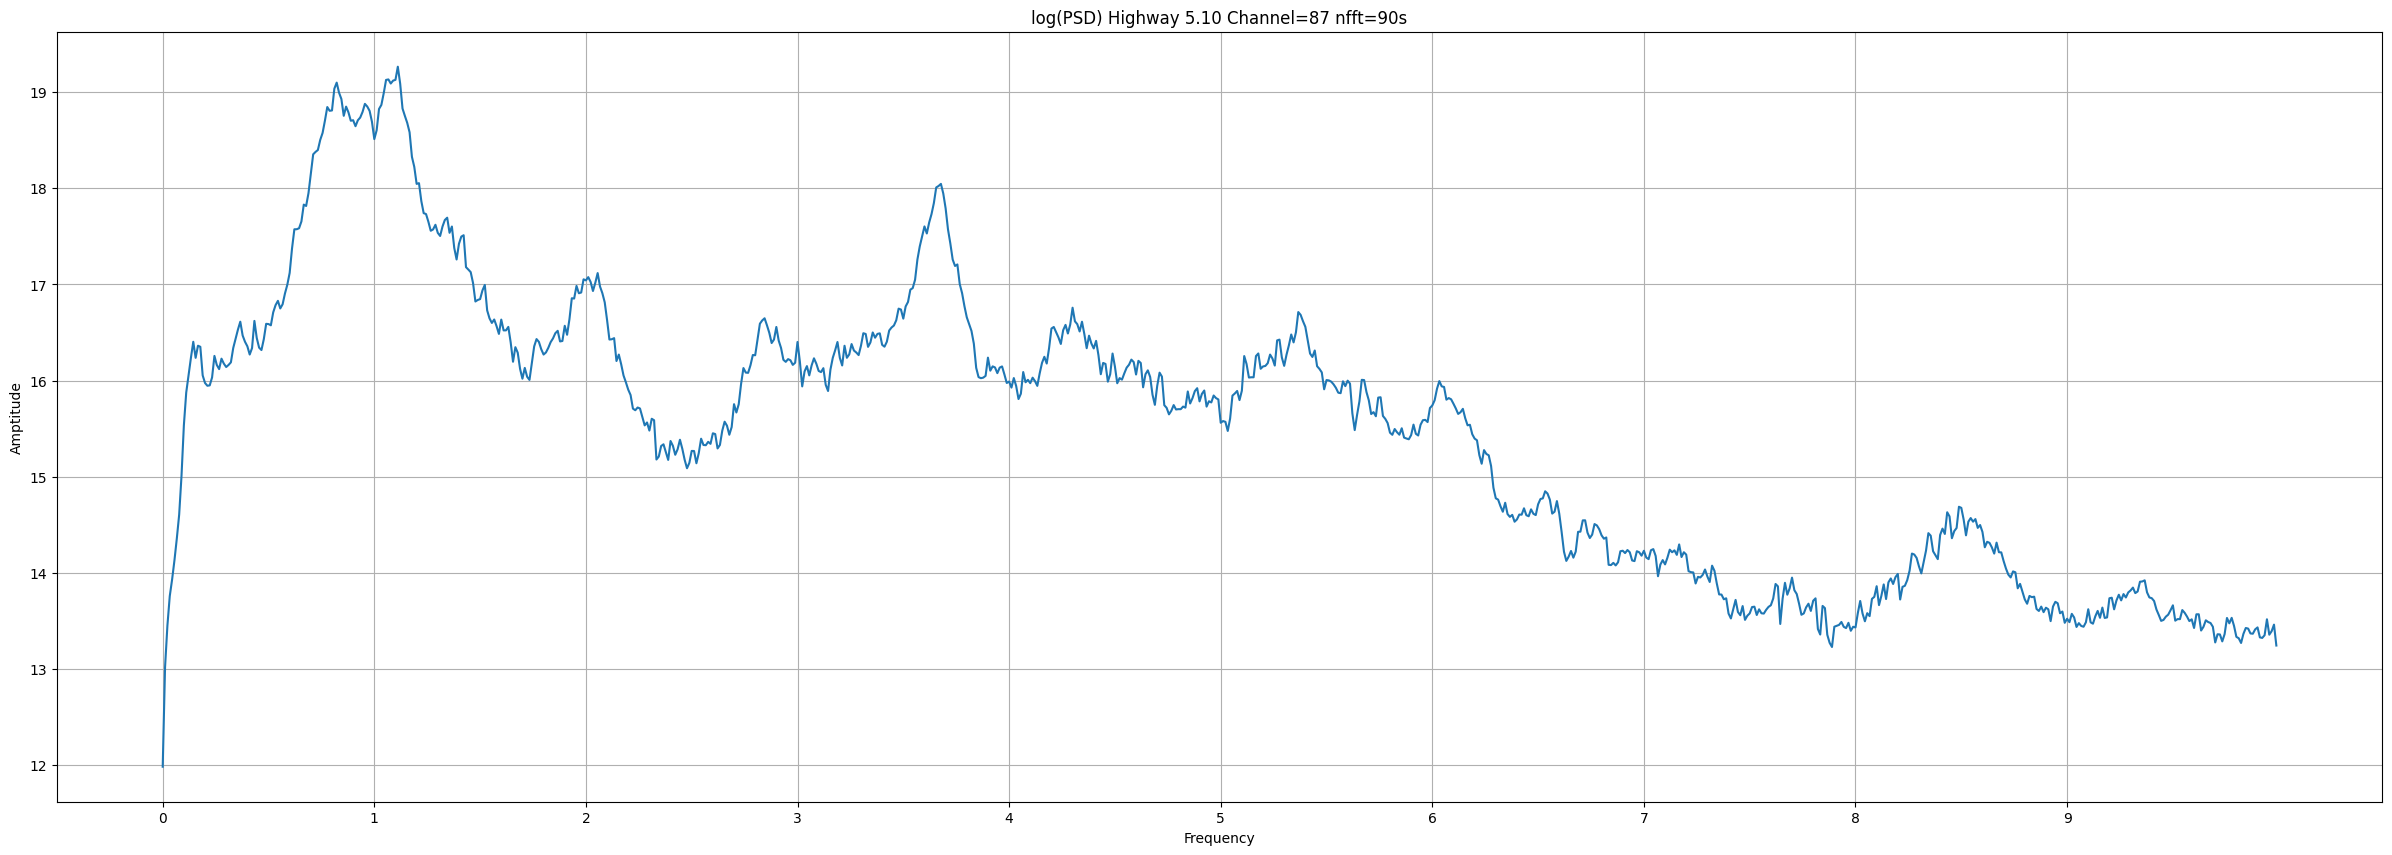

-----------read 398 ------------
1
1
(21, 45001)
21
(45001,)
(900,)


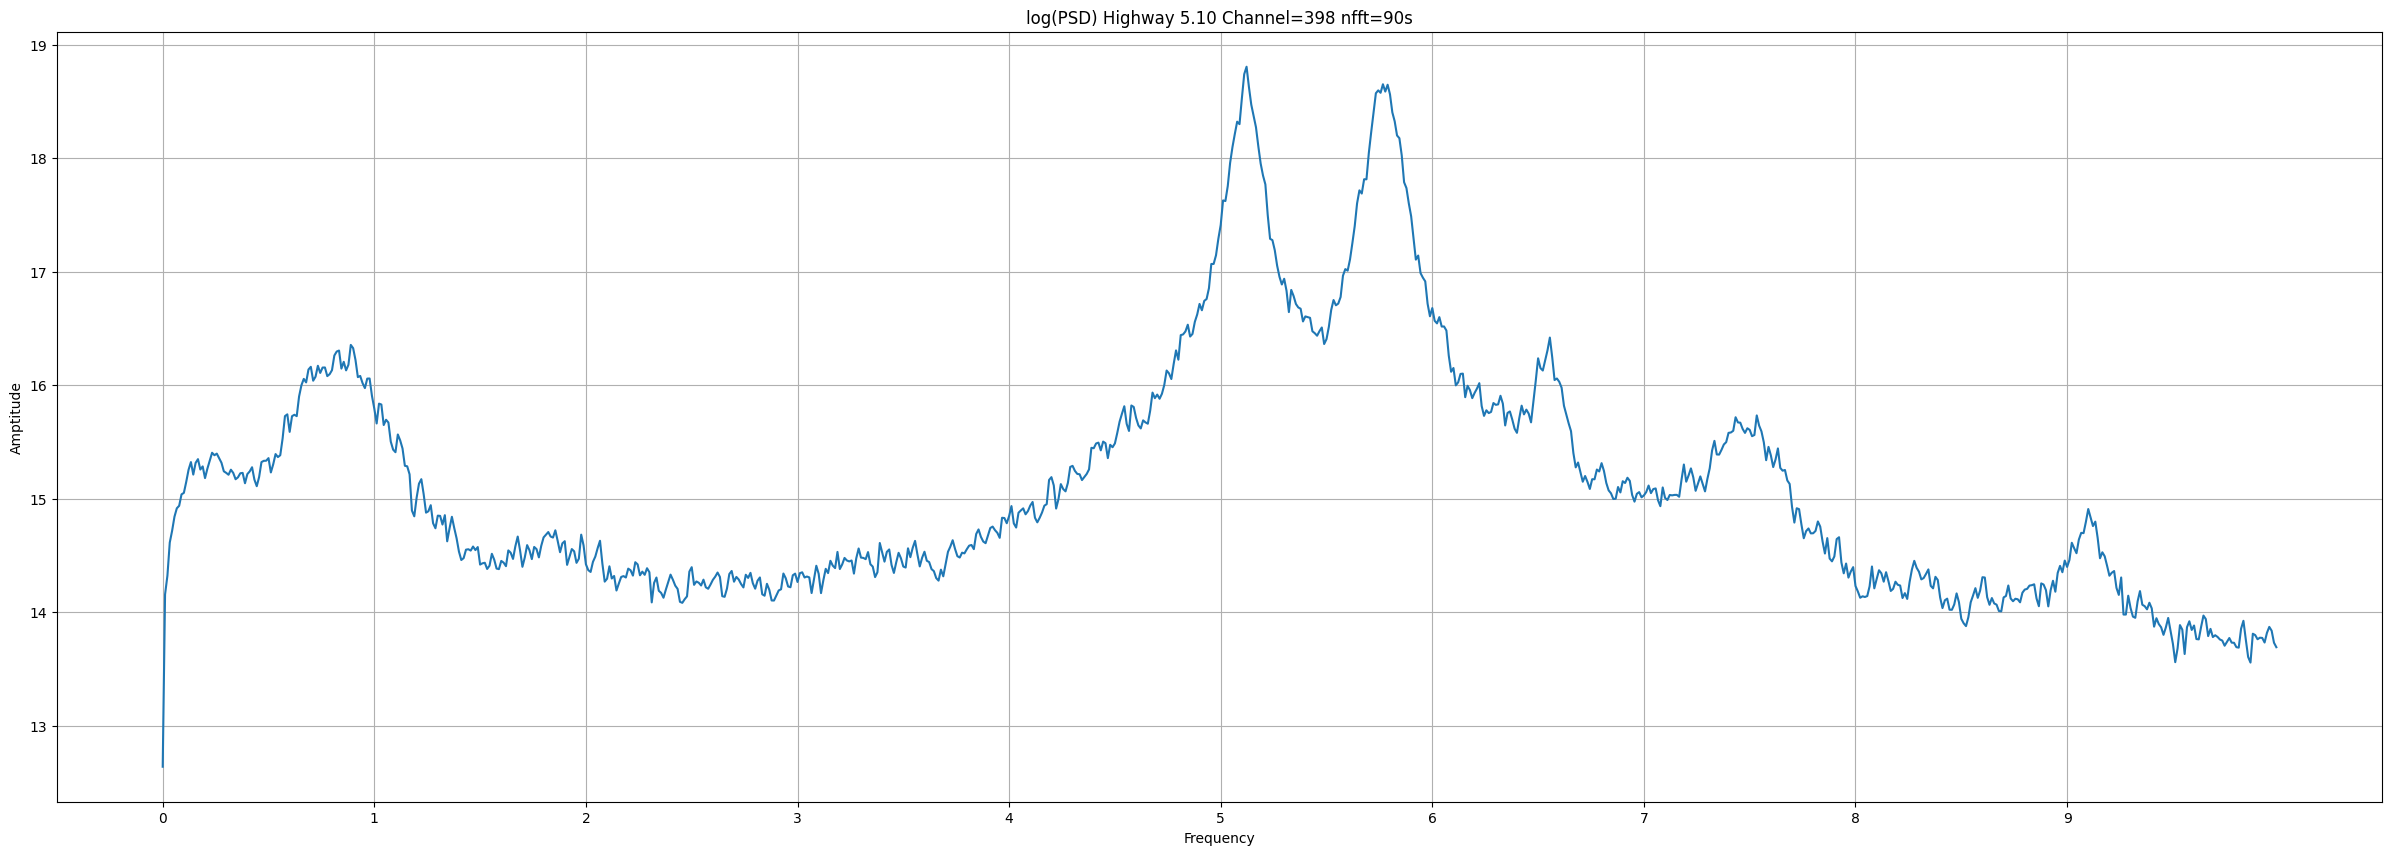

-----------read 430 ------------
1
1
(21, 45001)
21
(45001,)
(900,)


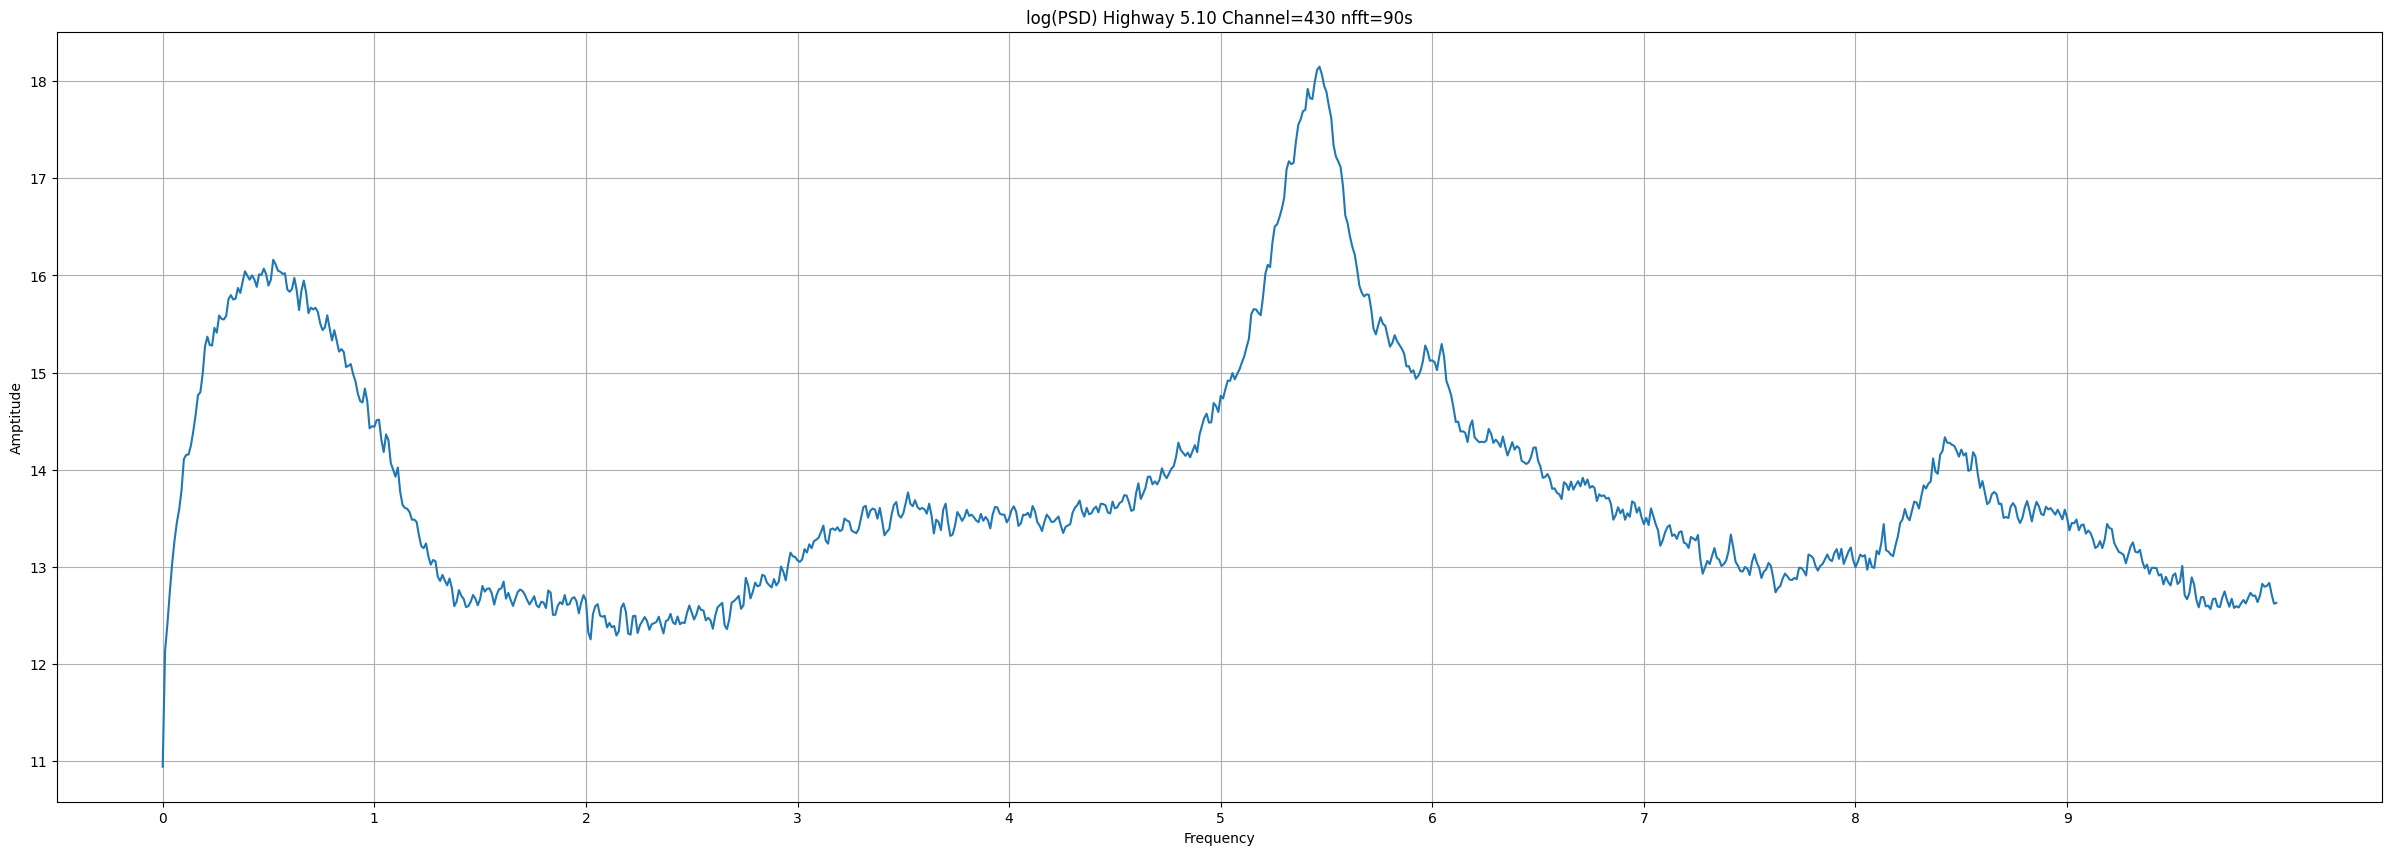

-----------read 511 ------------
1
1
(21, 45001)
21
(45001,)
(900,)


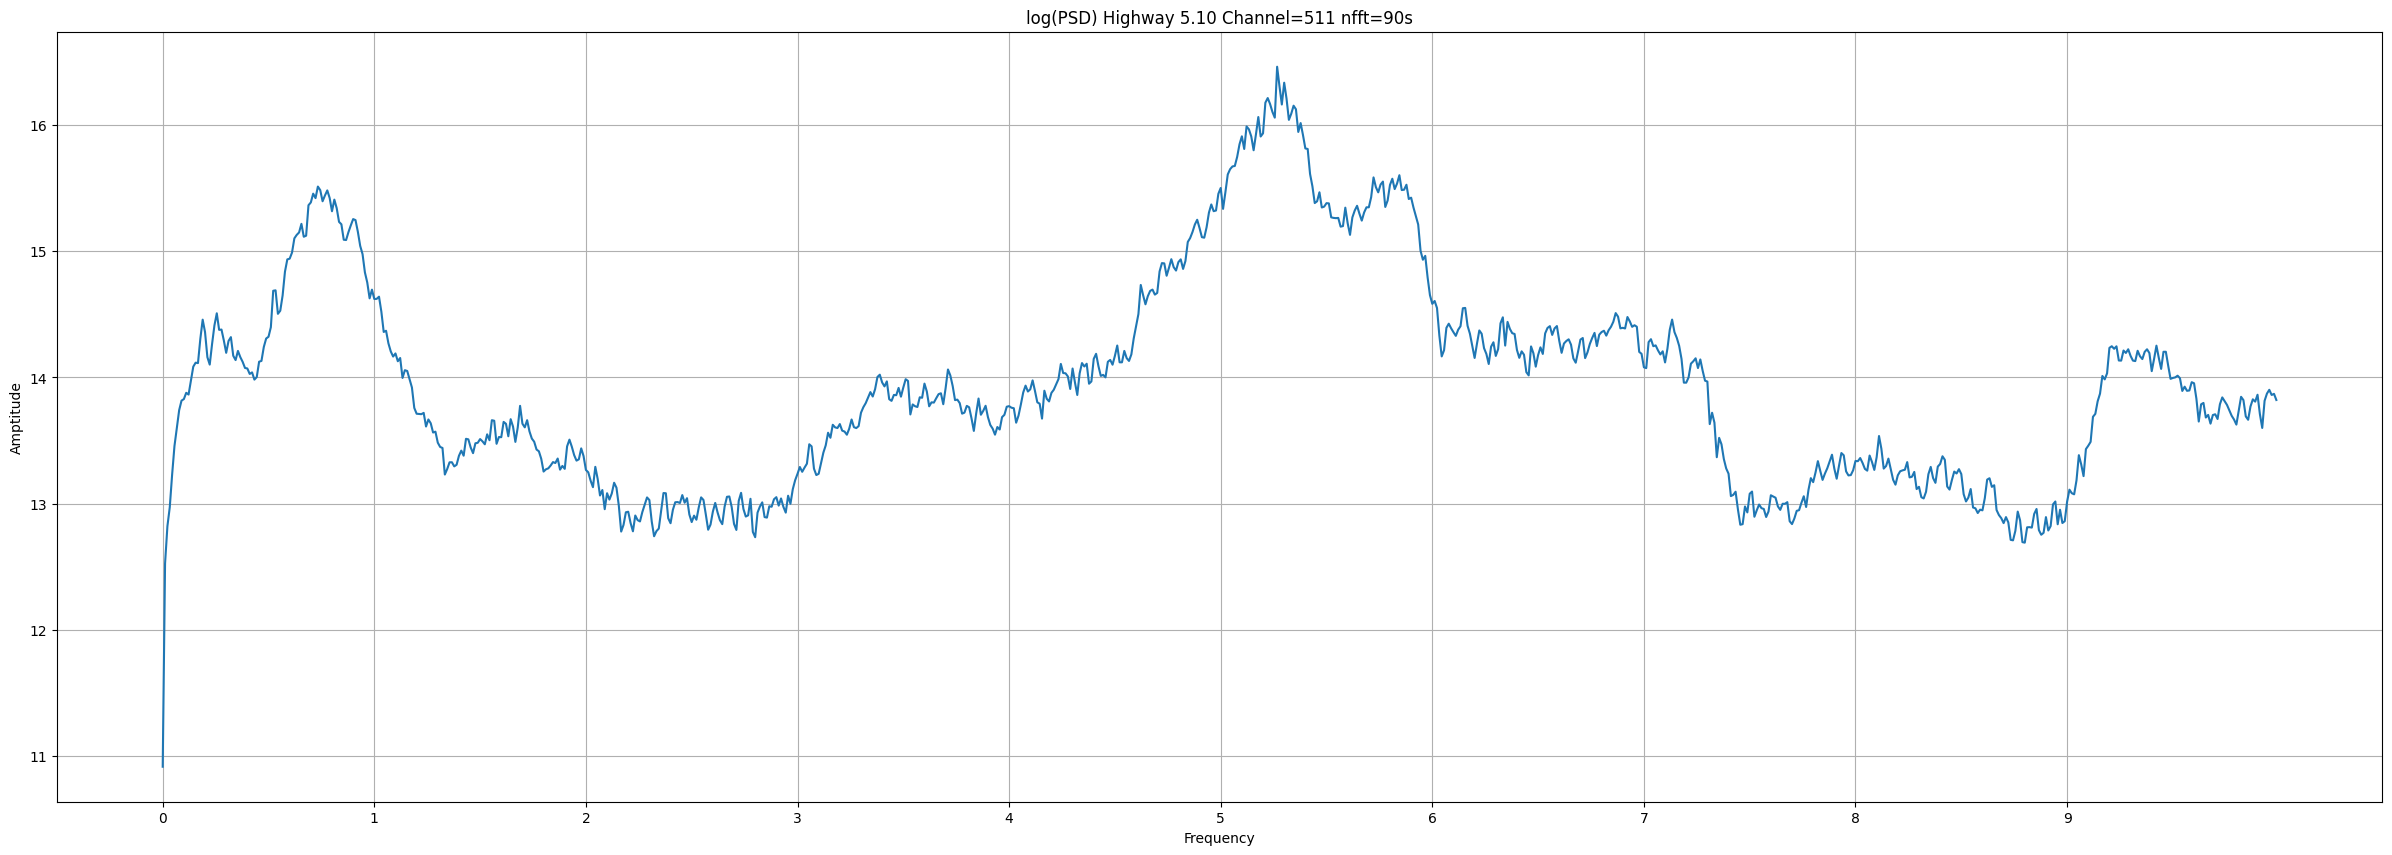

-----------read 606 ------------
1
1
(21, 45001)
21
(45001,)
(900,)


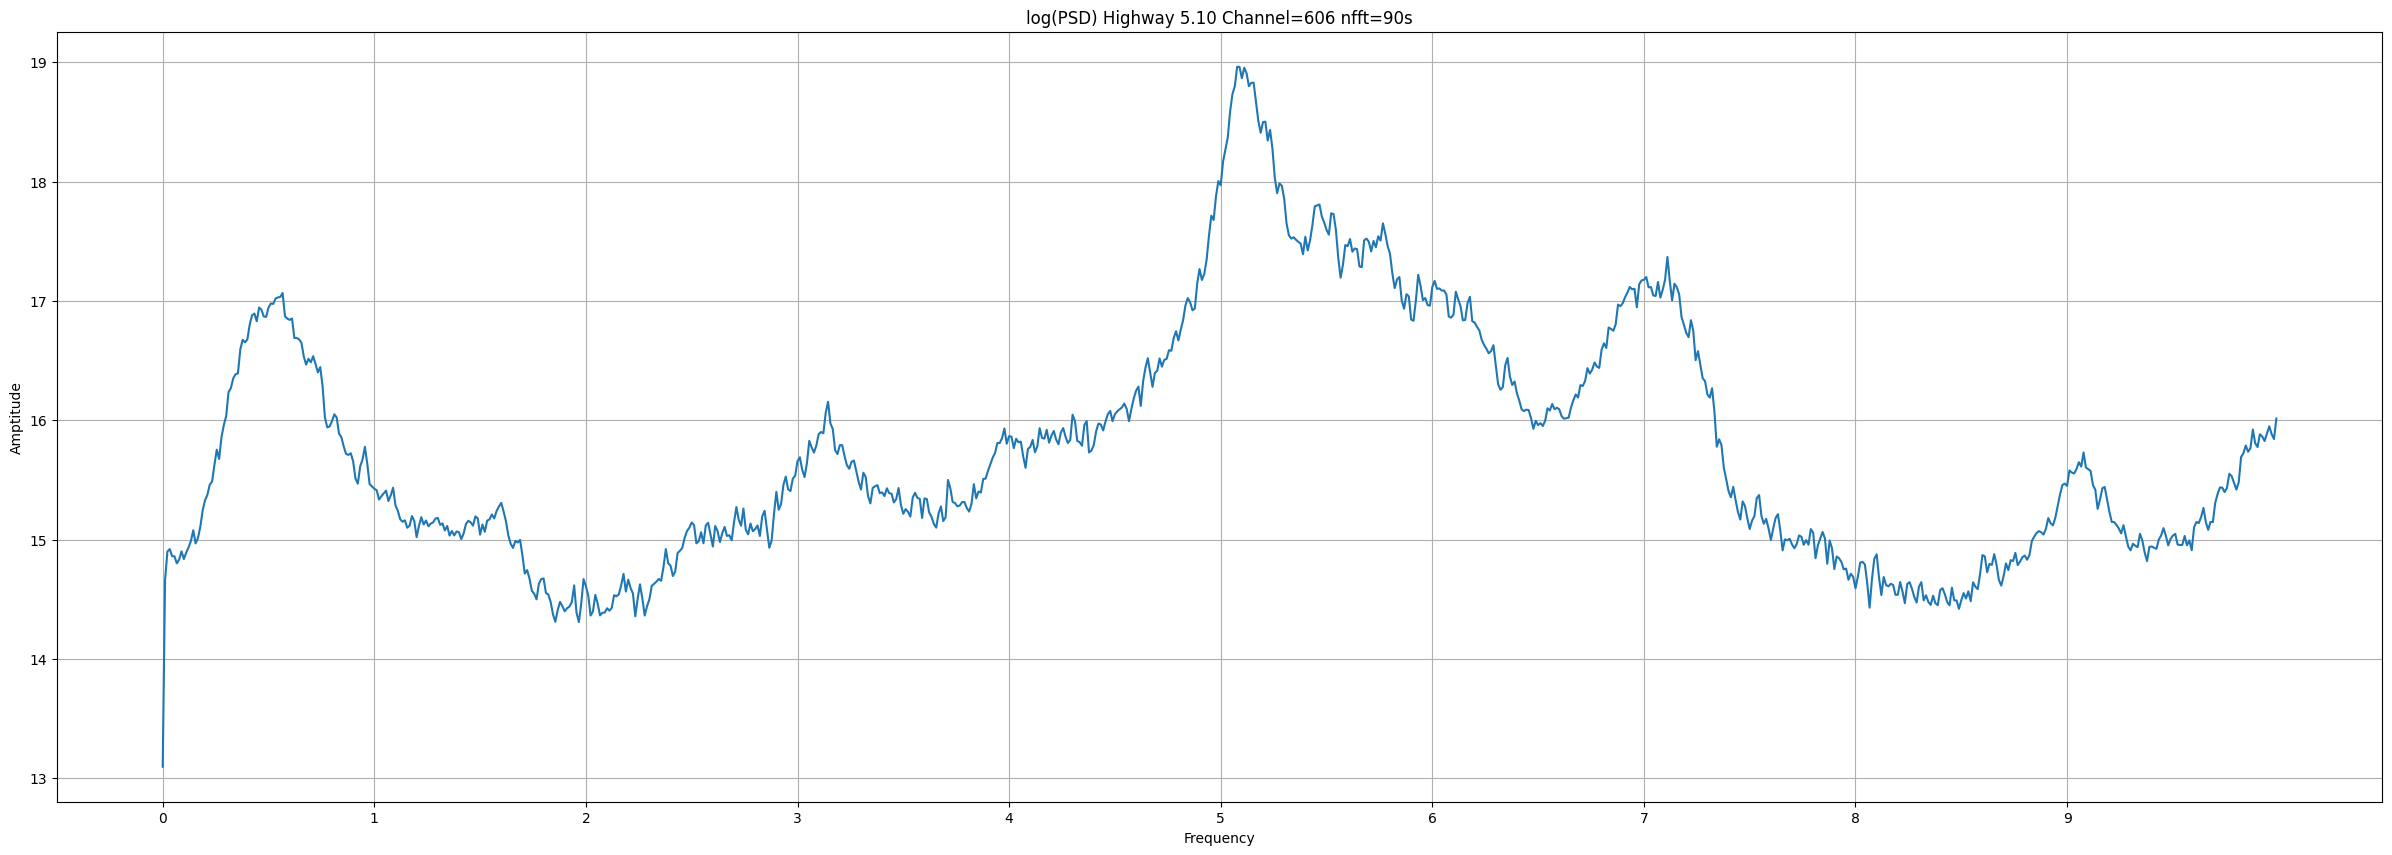

-----------read 682 ------------
1
1
(21, 45001)
21
(45001,)
(900,)


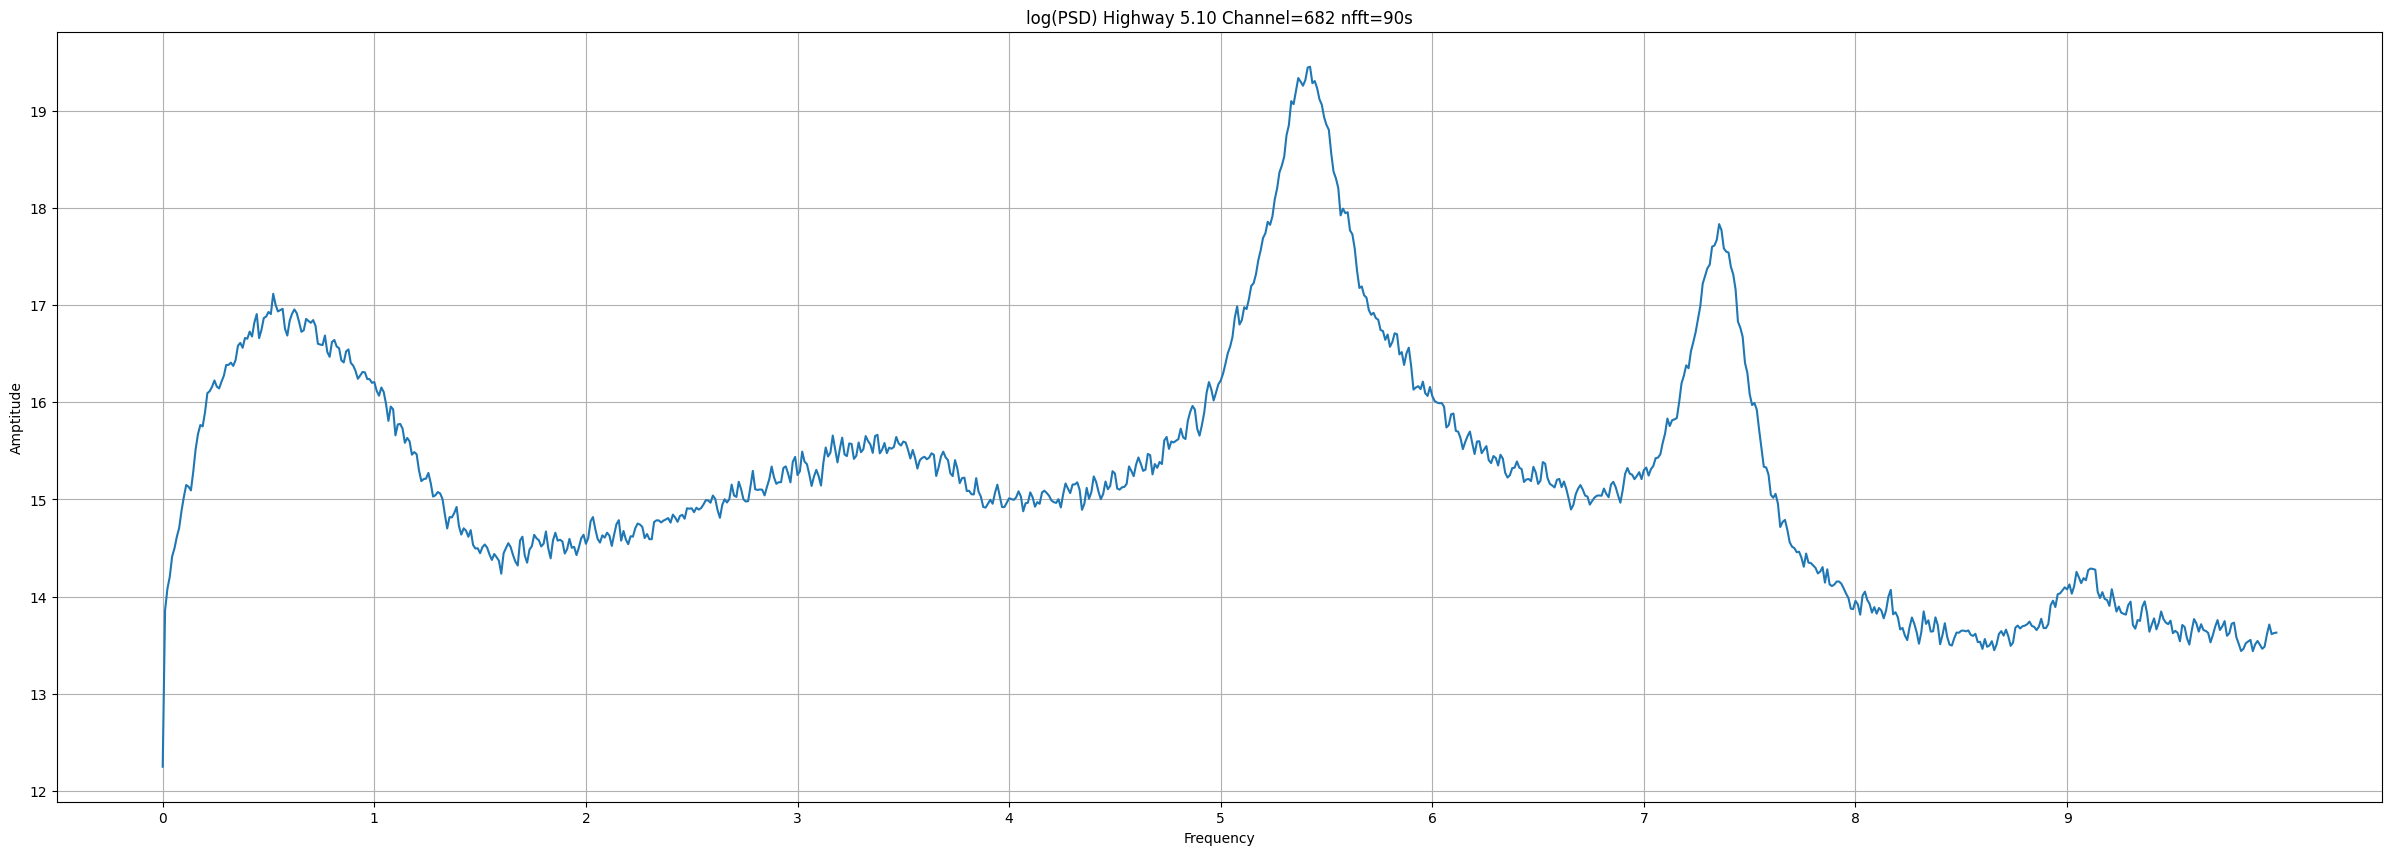

-----------read 754 ------------
1
1
(21, 45001)
21
(45001,)
(900,)


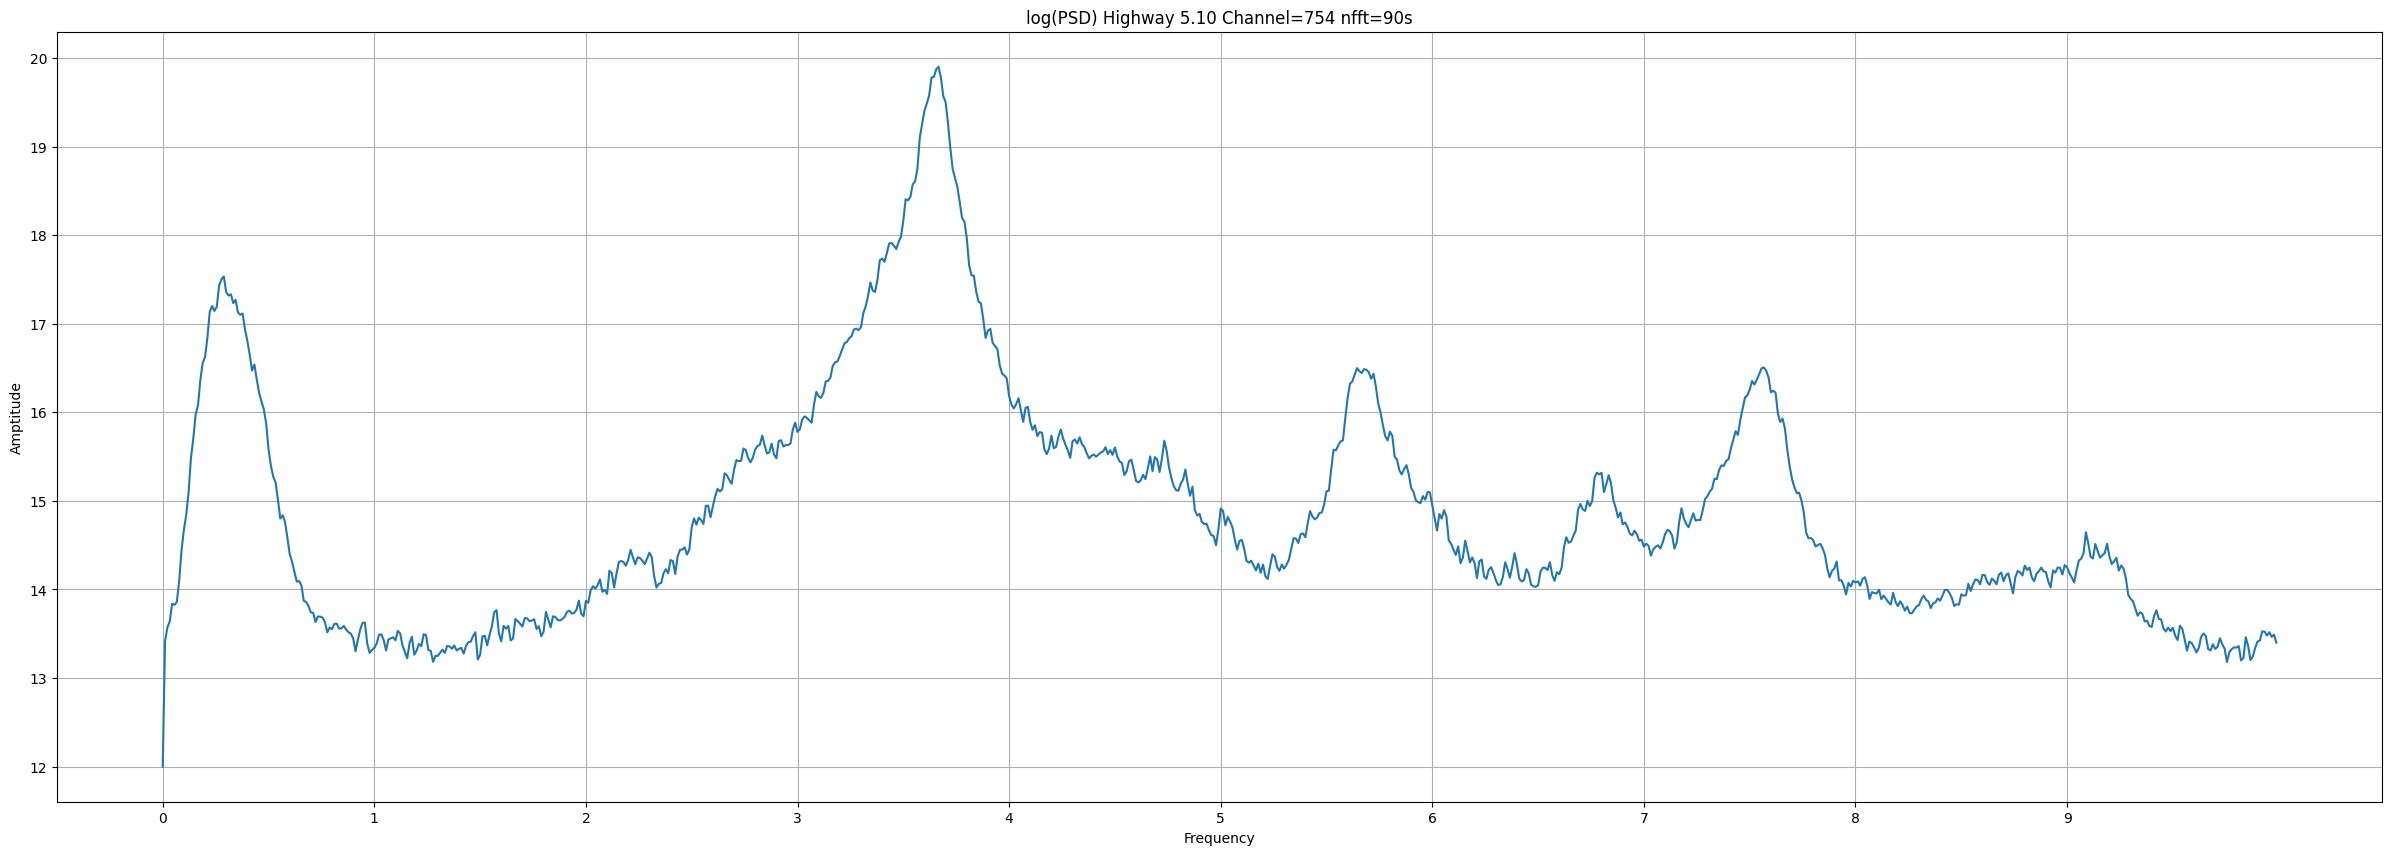

-----------read 812 ------------
1
1
(21, 45001)
21
(45001,)
(900,)


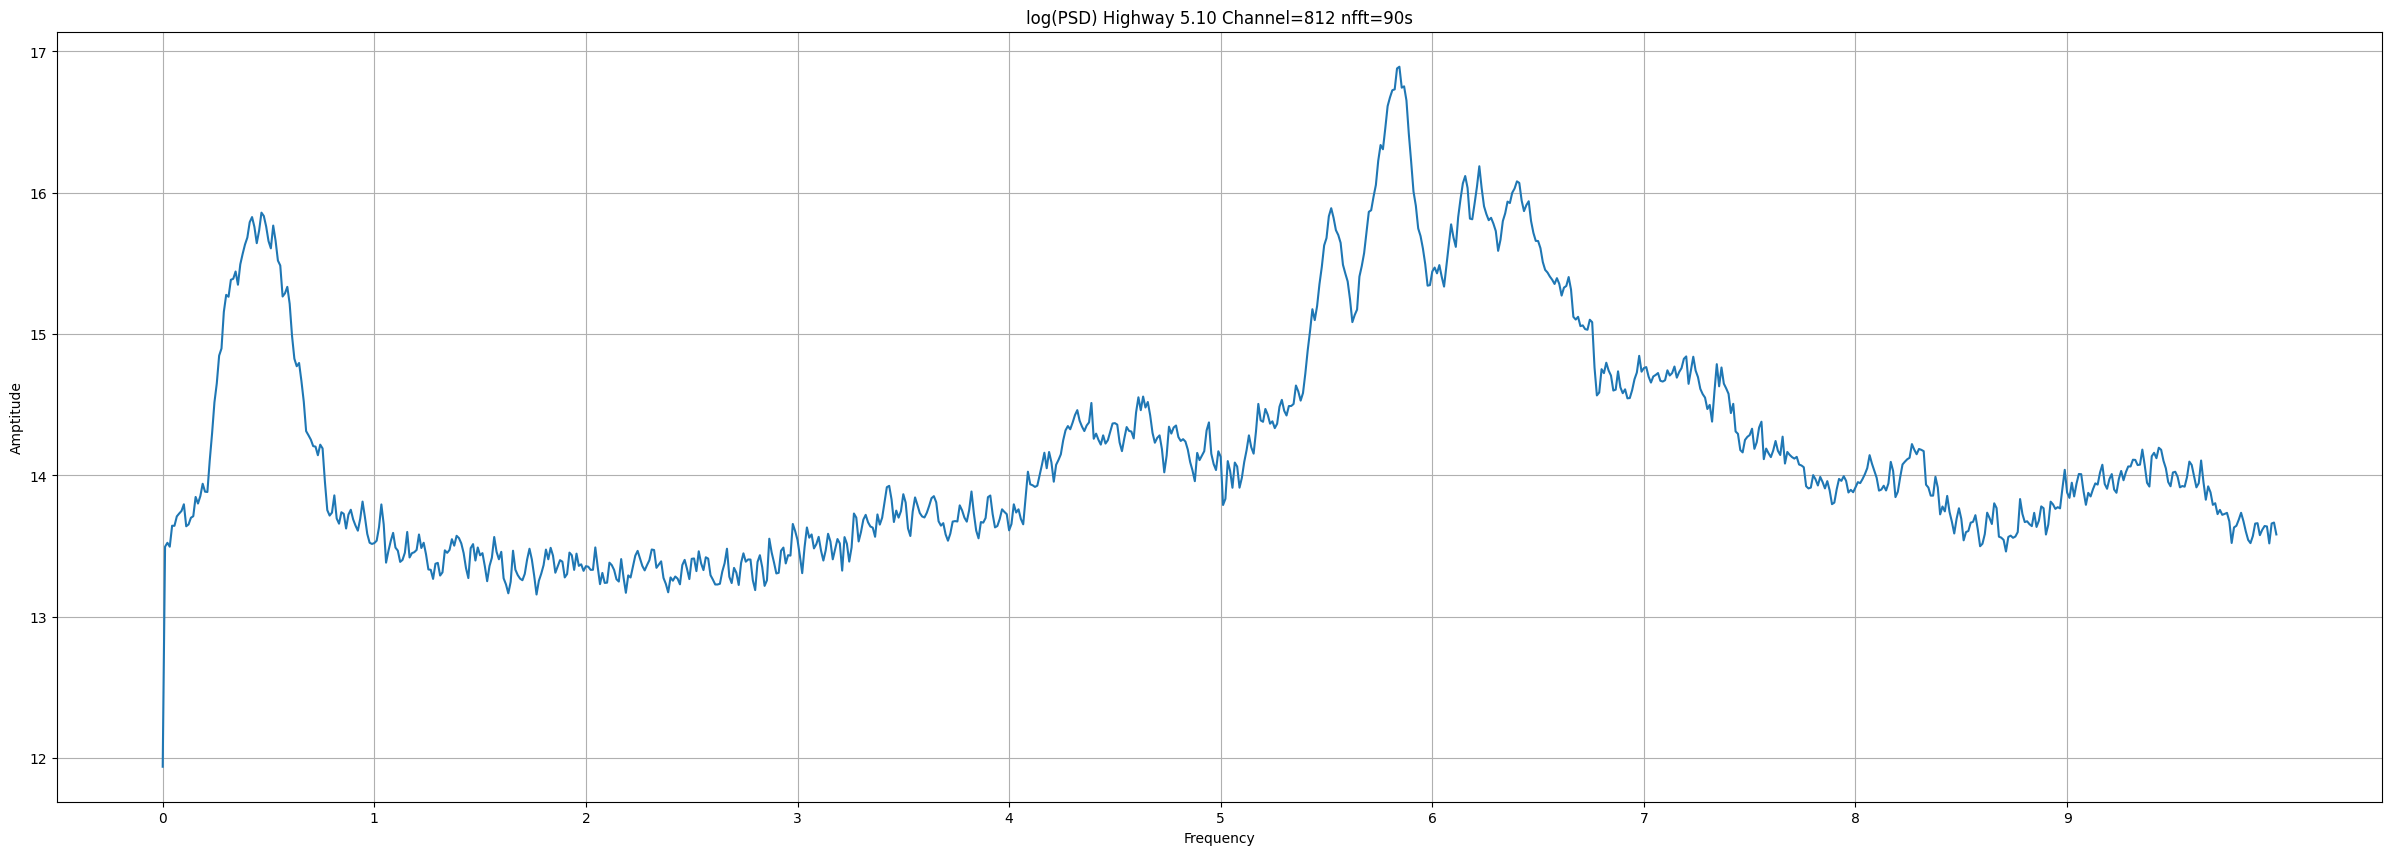

-----------read 876 ------------
1
1
(21, 45001)
21
(45001,)
(900,)


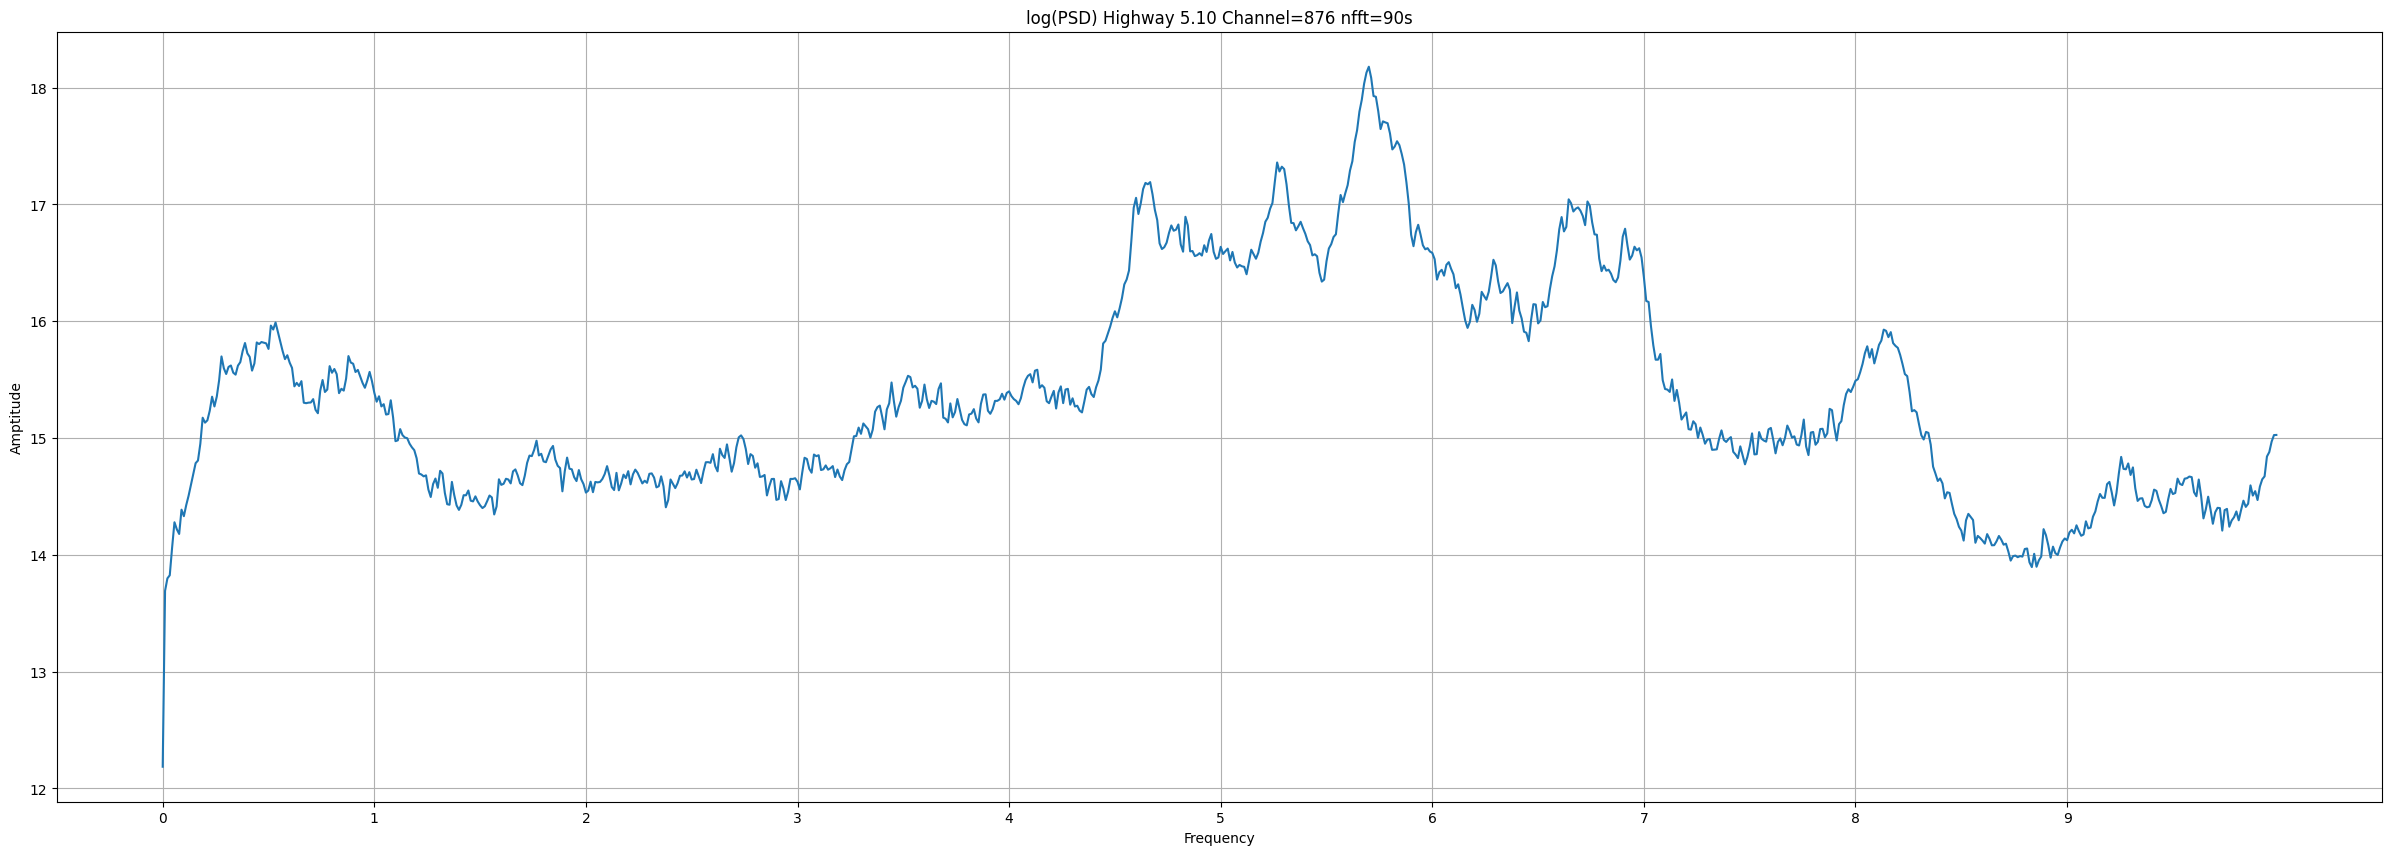

-----------read 948 ------------
1
1
(21, 45001)
21
(45001,)
(900,)


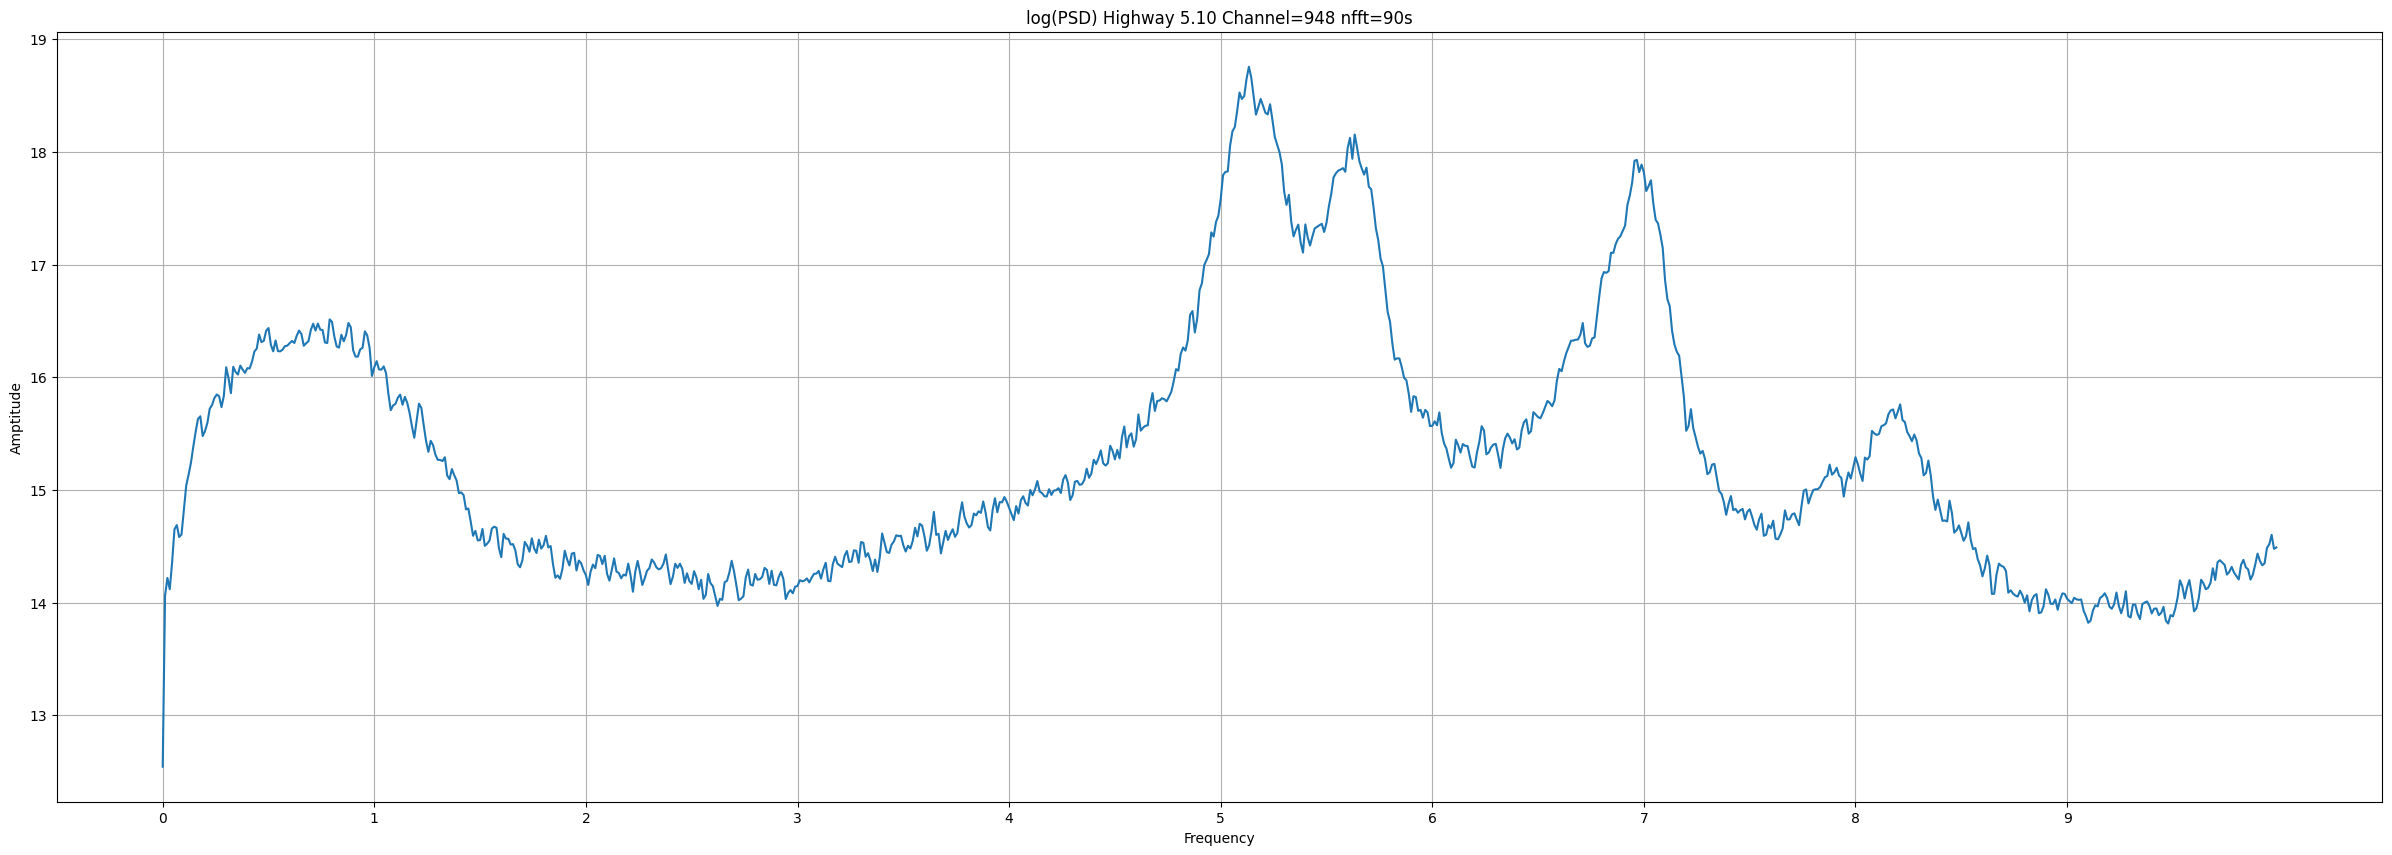

-----------read 1034 ------------
1
1
(21, 45001)
21
(45001,)
(900,)


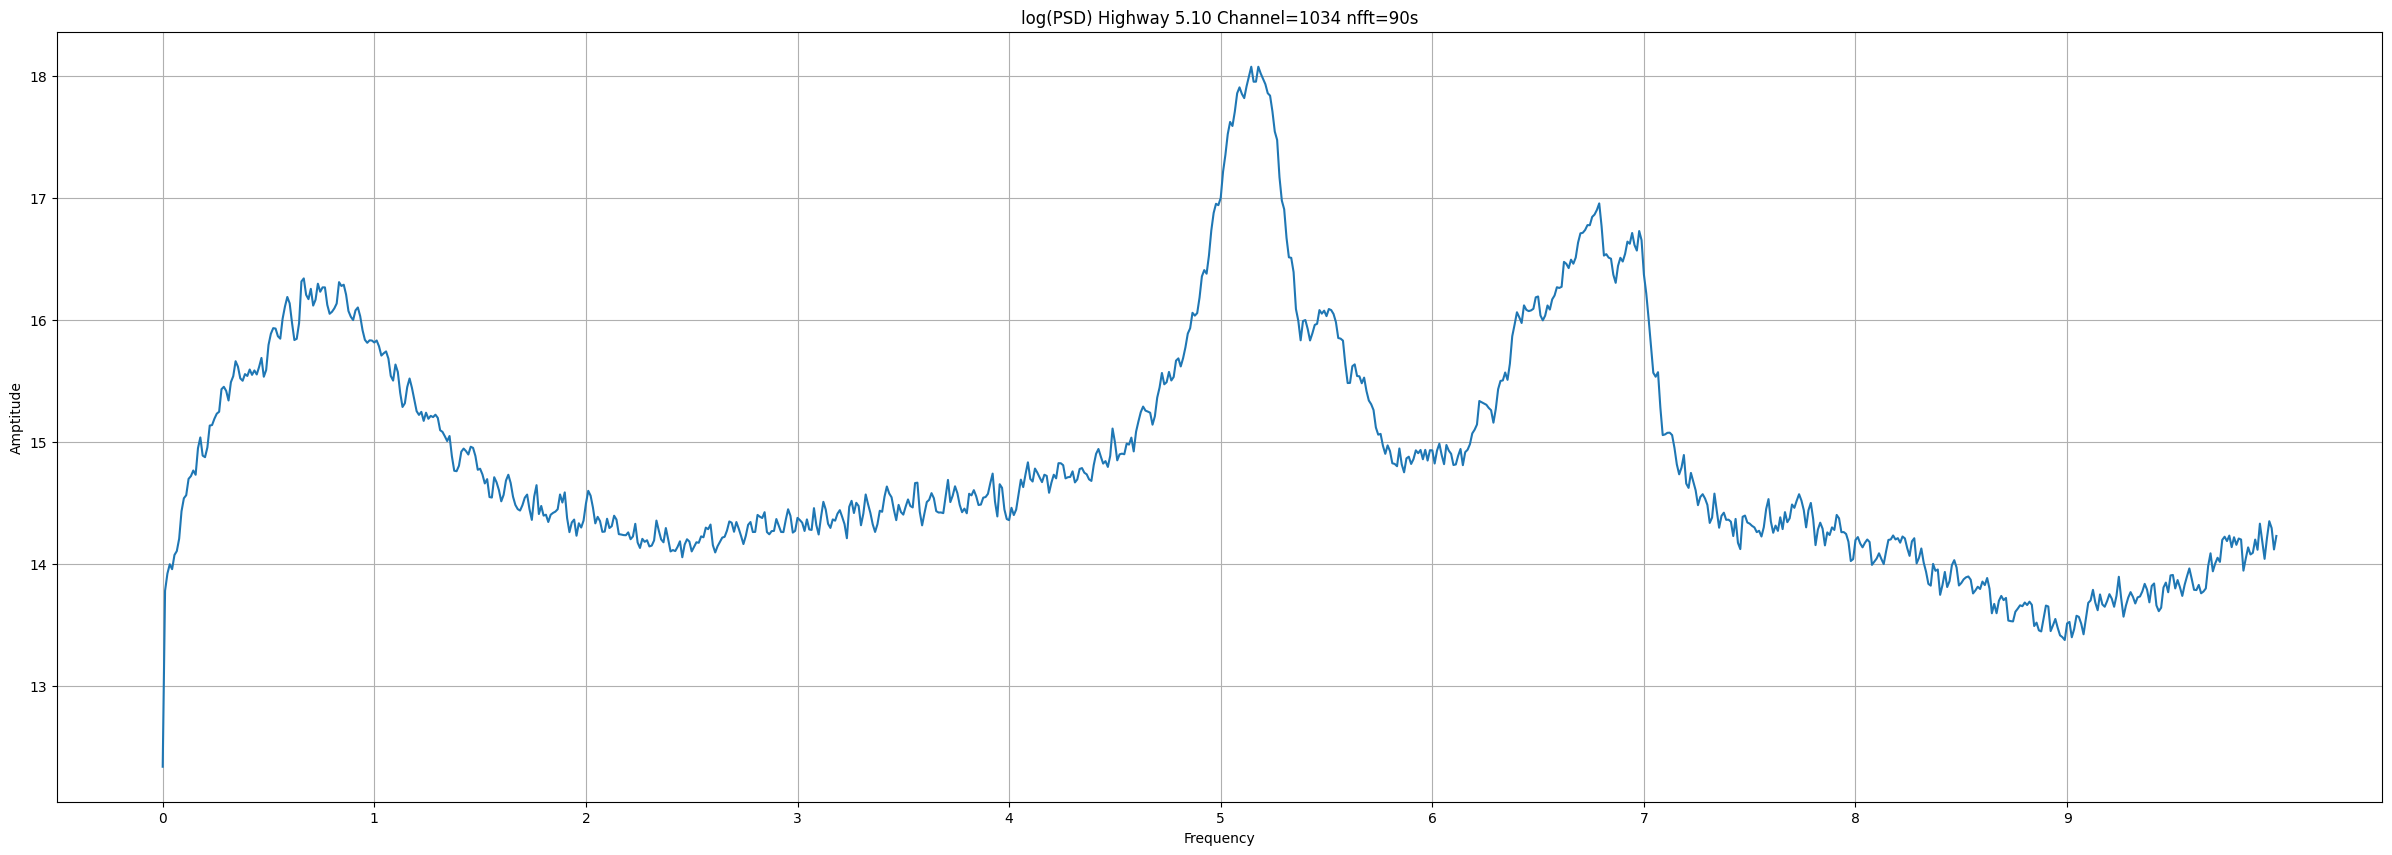

-----------read 1204 ------------
1
1
(21, 45001)
21
(45001,)
(900,)


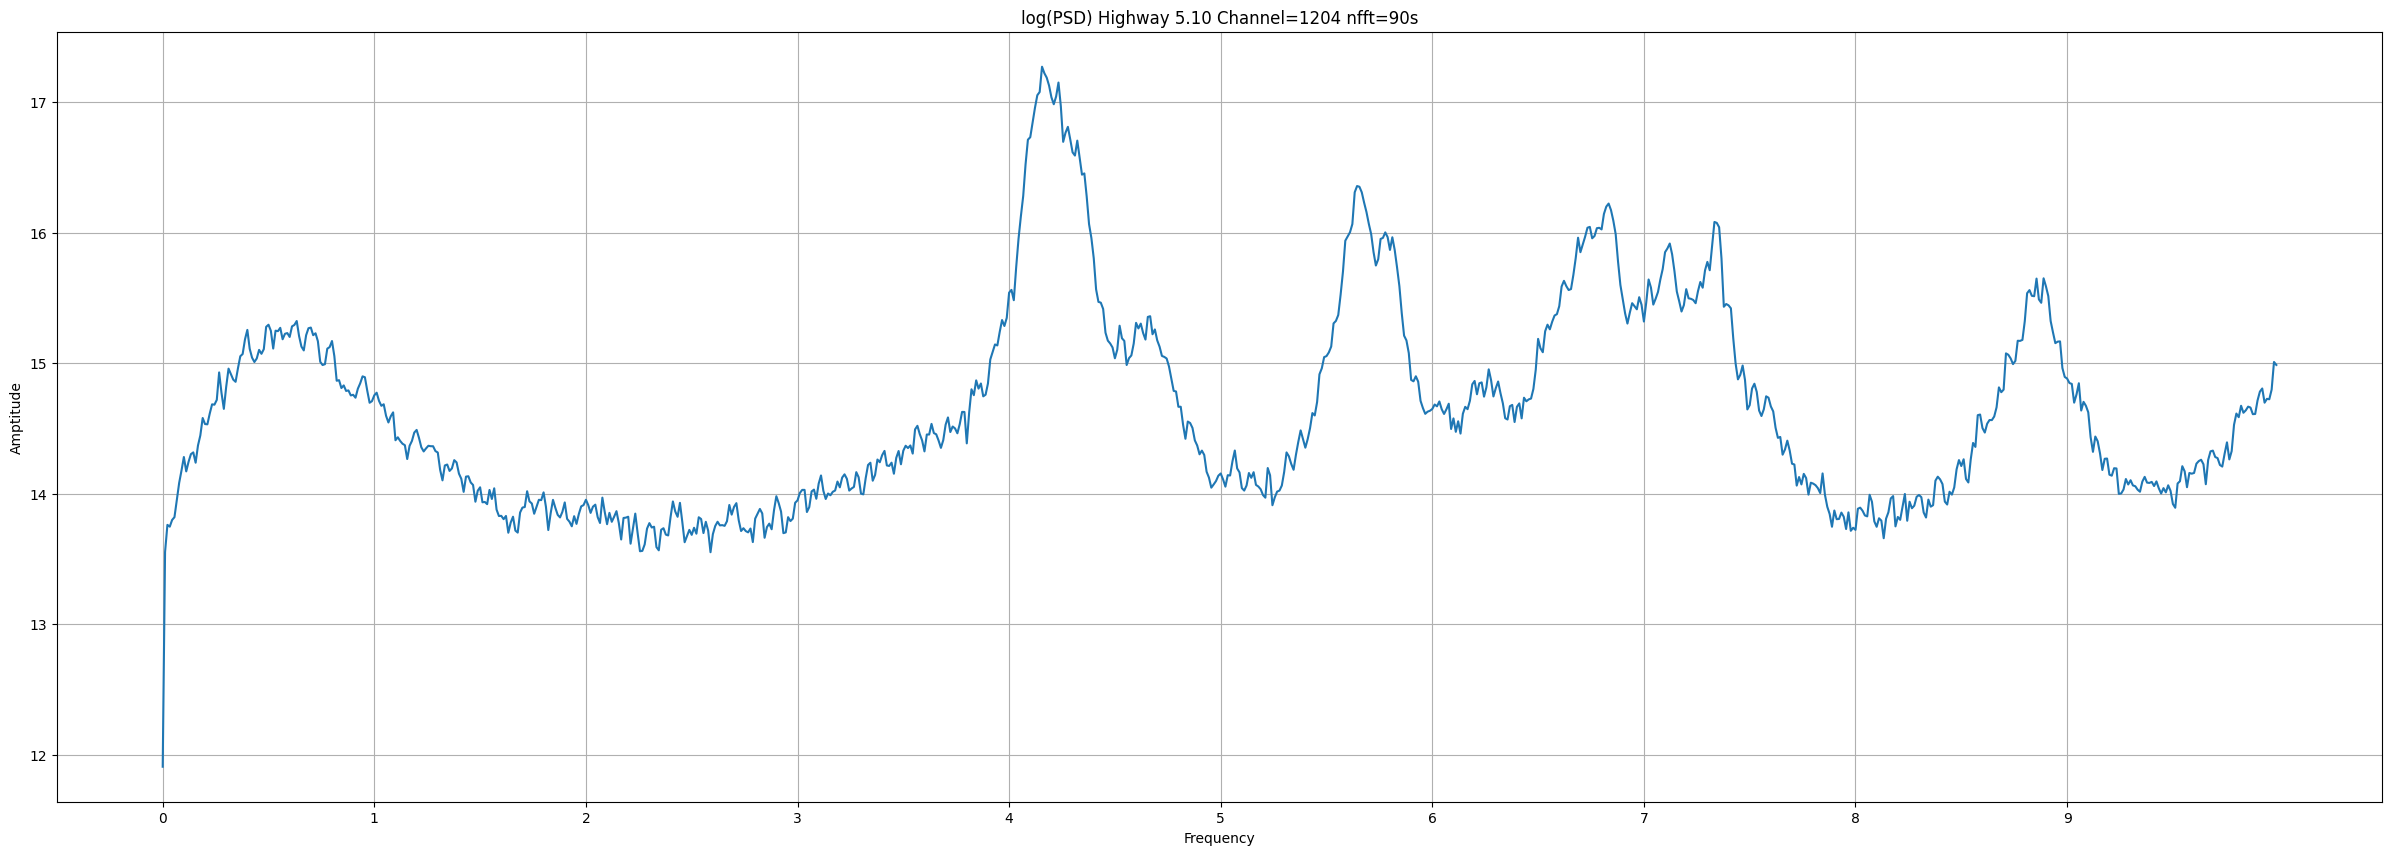

-----------read 1326 ------------
1
1
(21, 45001)
21
(45001,)
(900,)


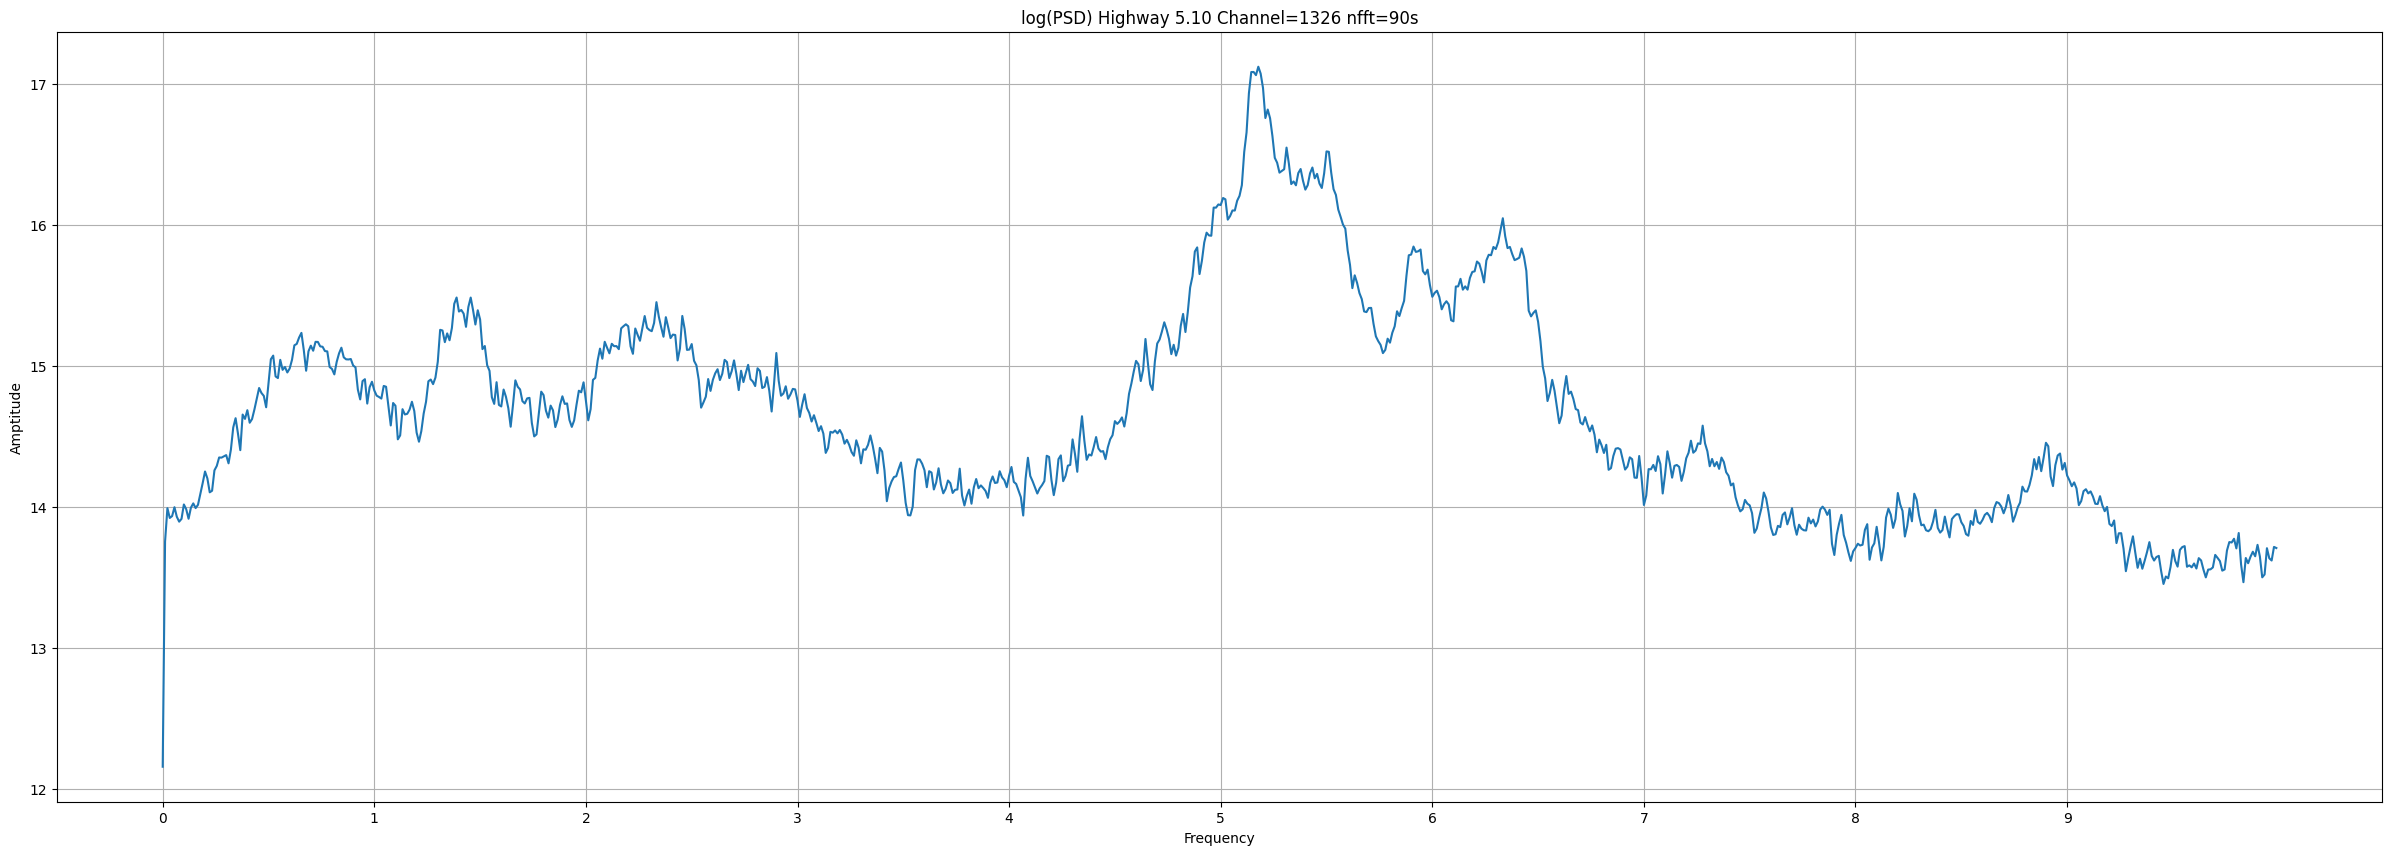

-----------read 1385 ------------
1
1
(21, 45001)
21
(45001,)
(900,)


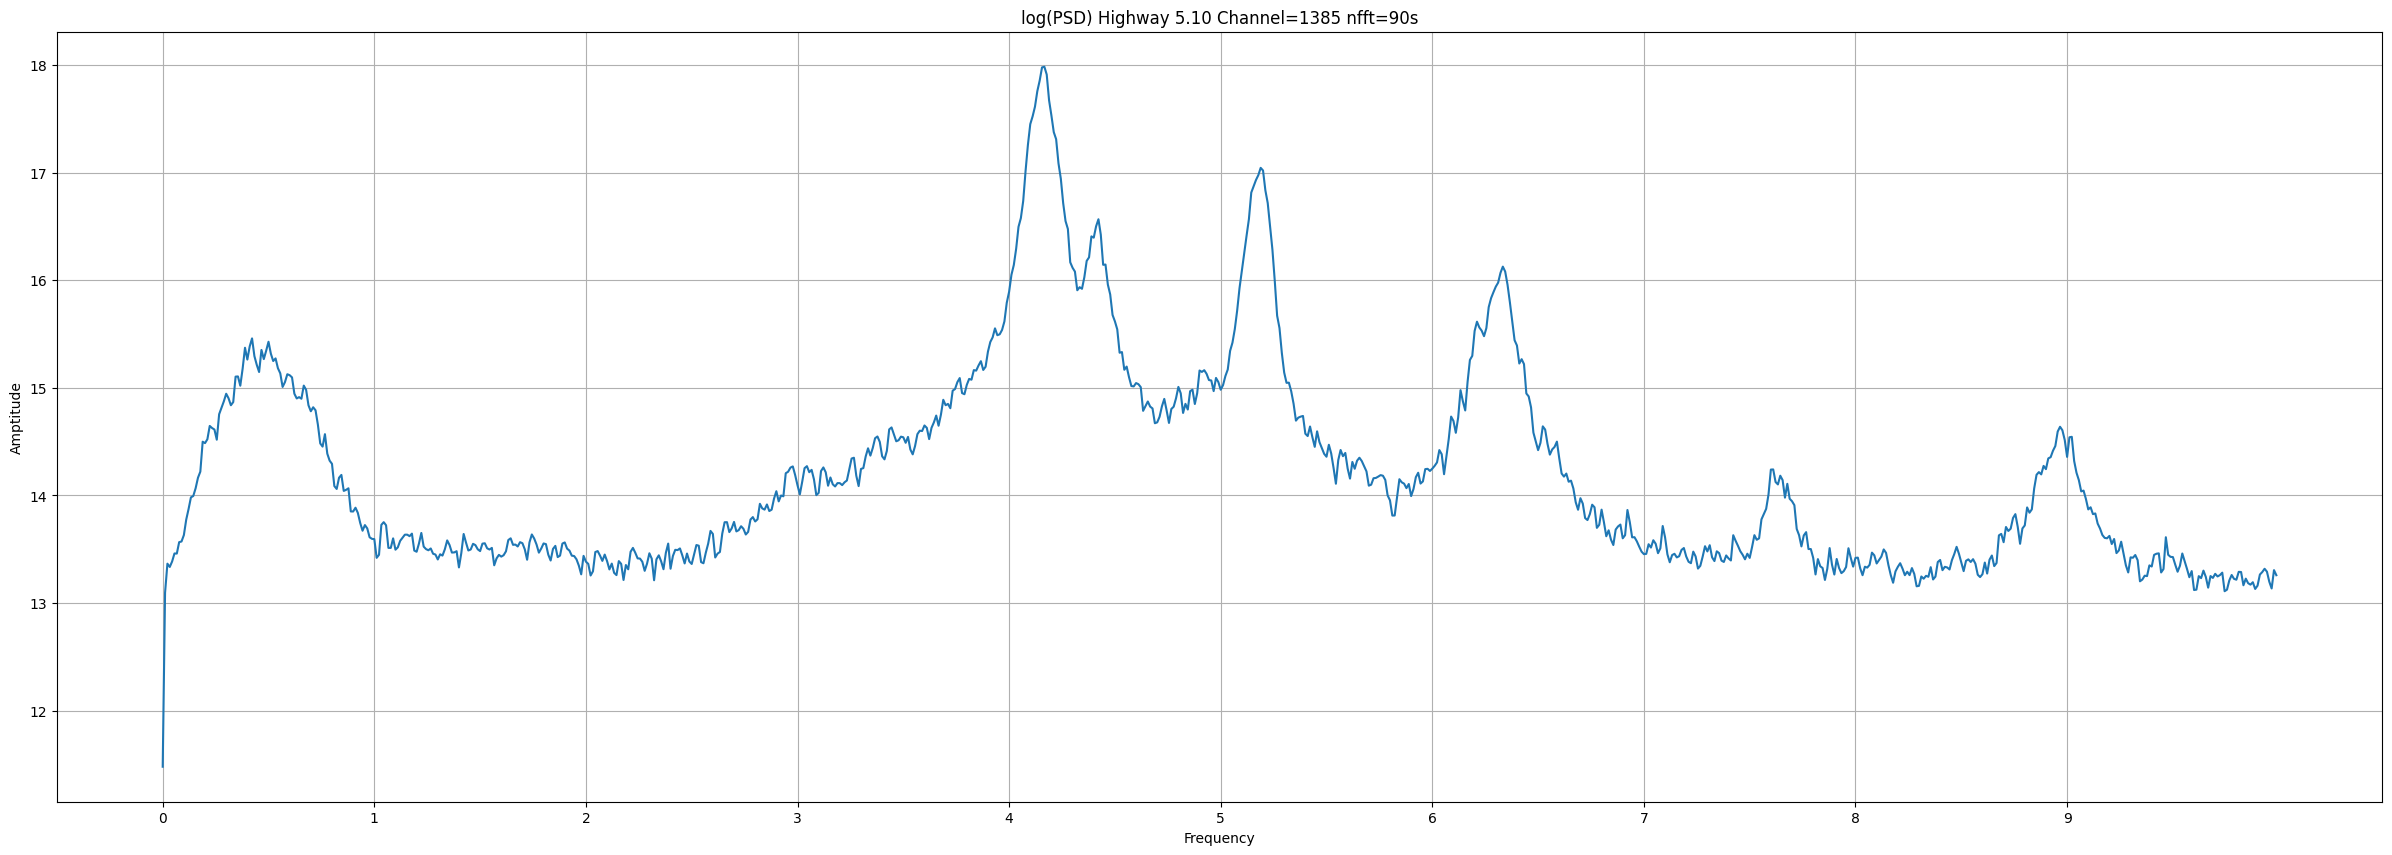

-----------read 1490 ------------
1
1
(21, 45001)
21
(45001,)
(900,)


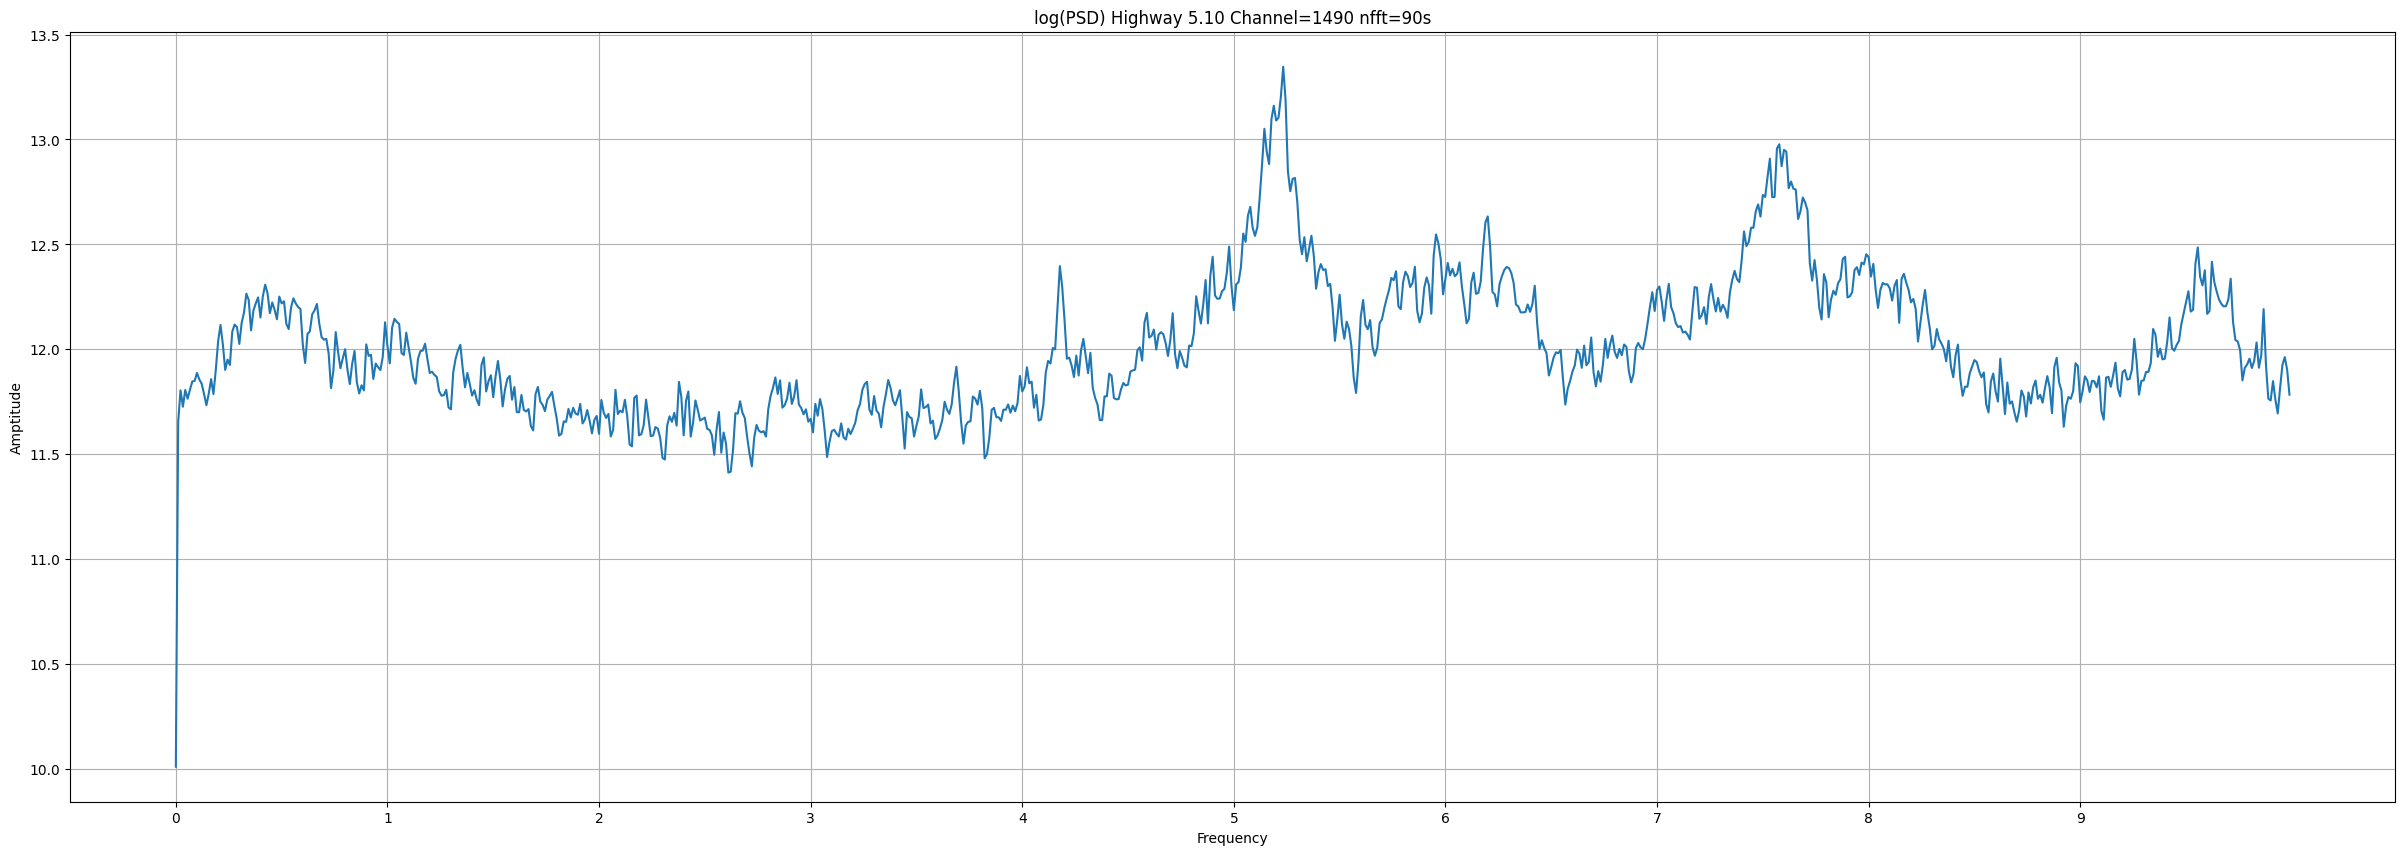

-----------read 1796 ------------
1
1
(21, 45001)
21
(45001,)
(900,)


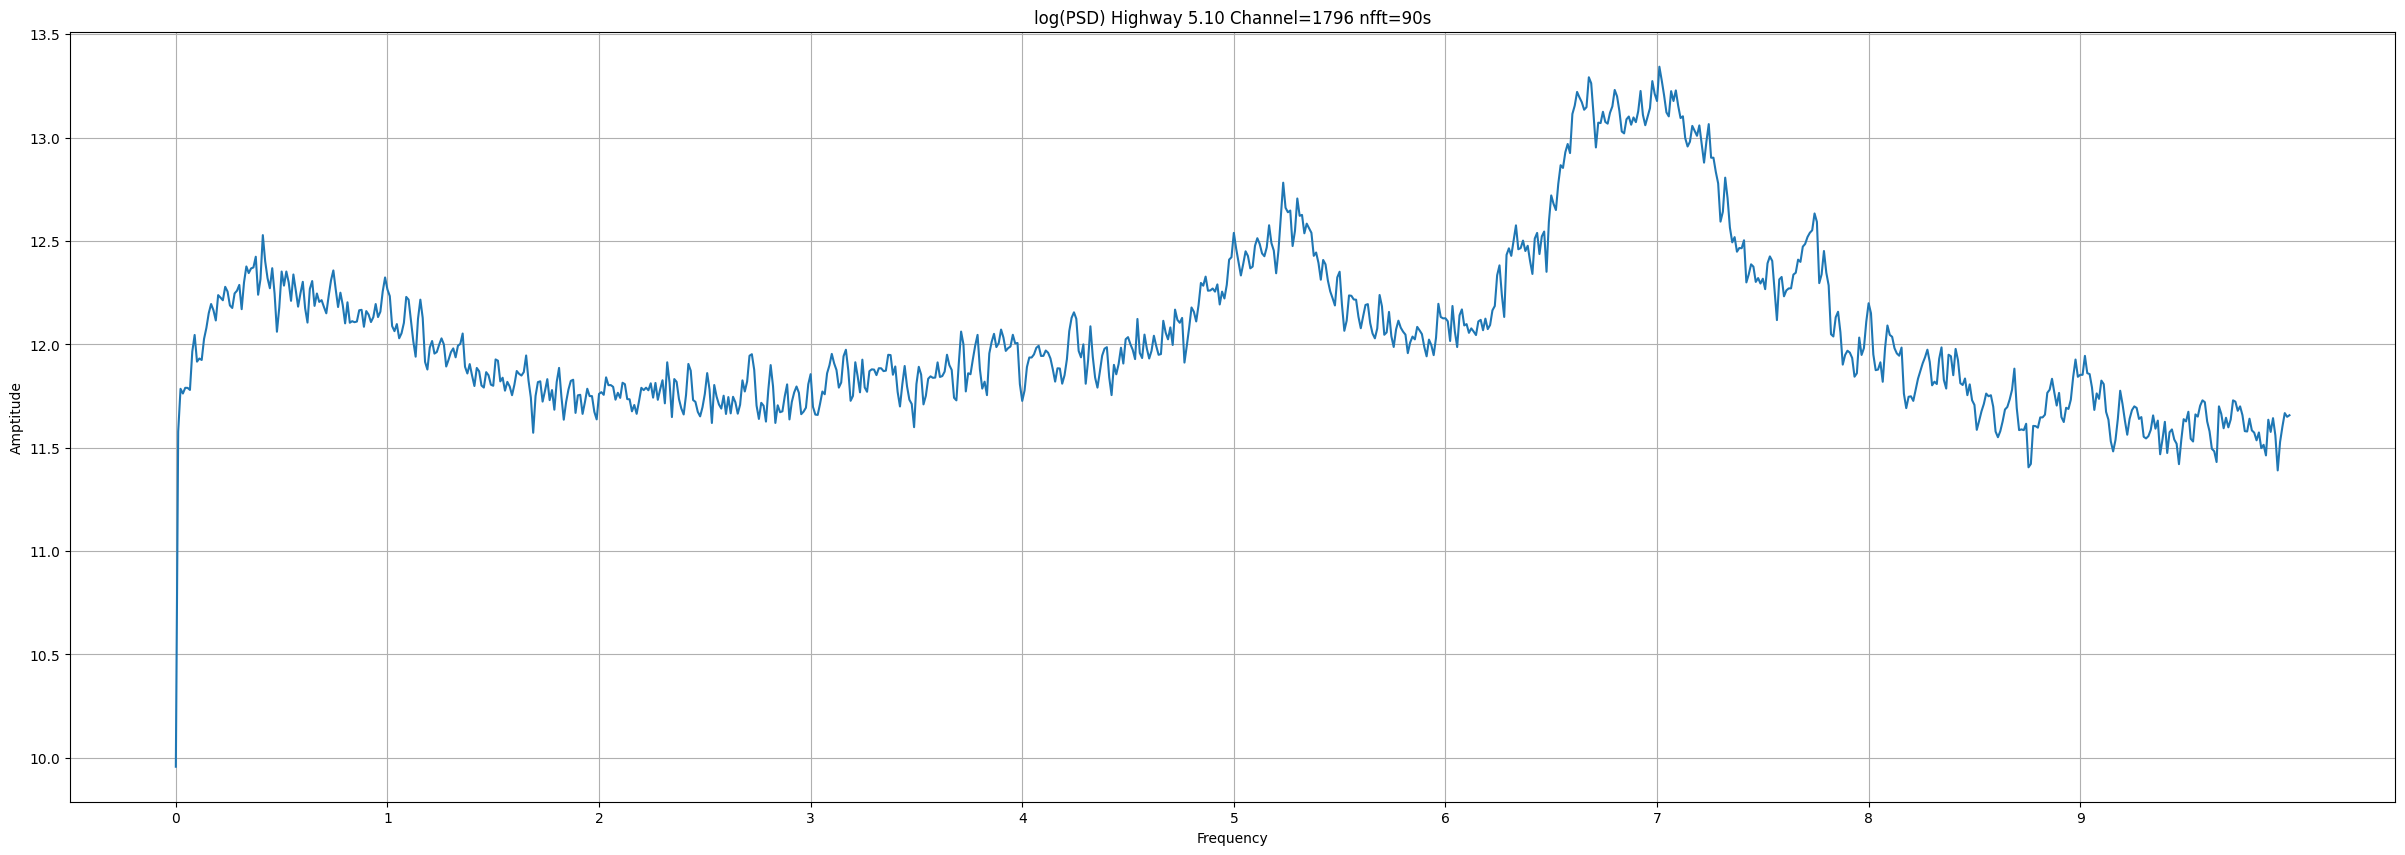

-----------read 1879 ------------
1
1
(21, 45001)
21
(45001,)
(900,)


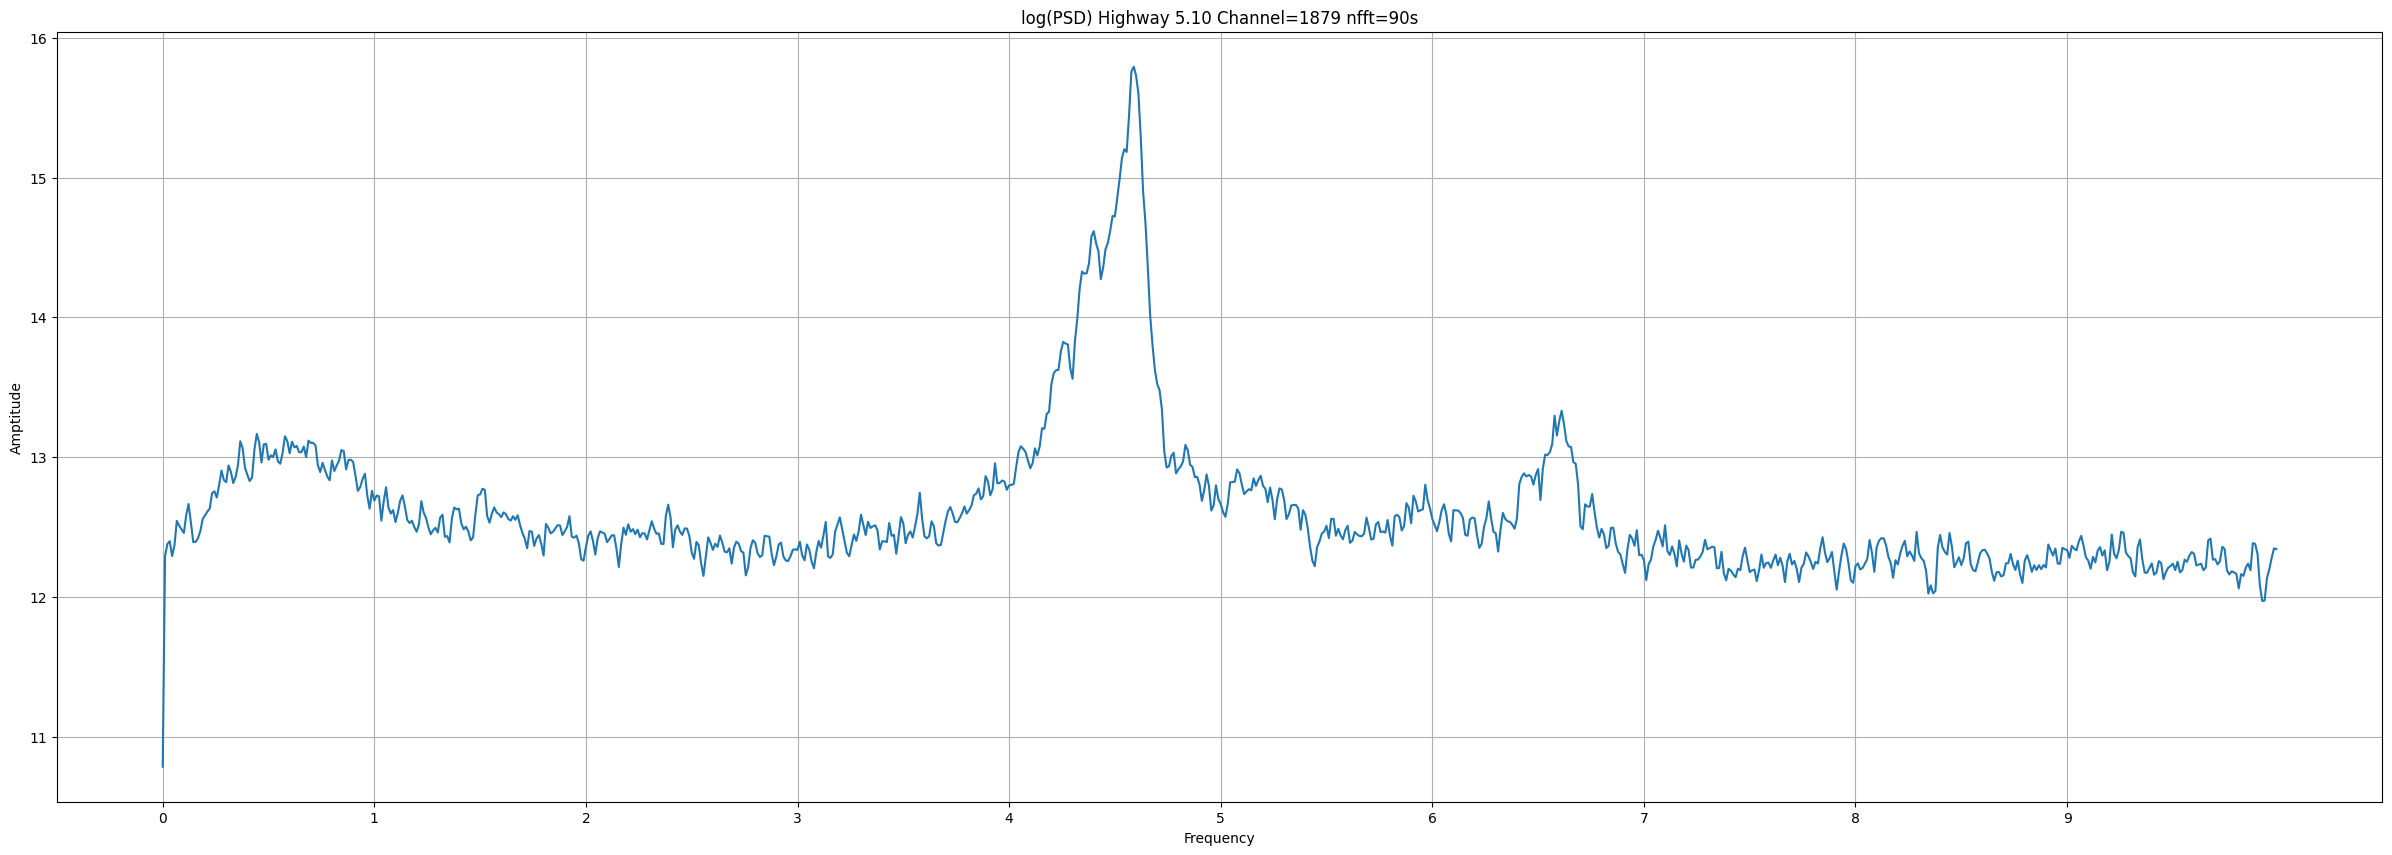

-----------read 1996 ------------
1
1
(21, 45001)
21
(45001,)
(900,)


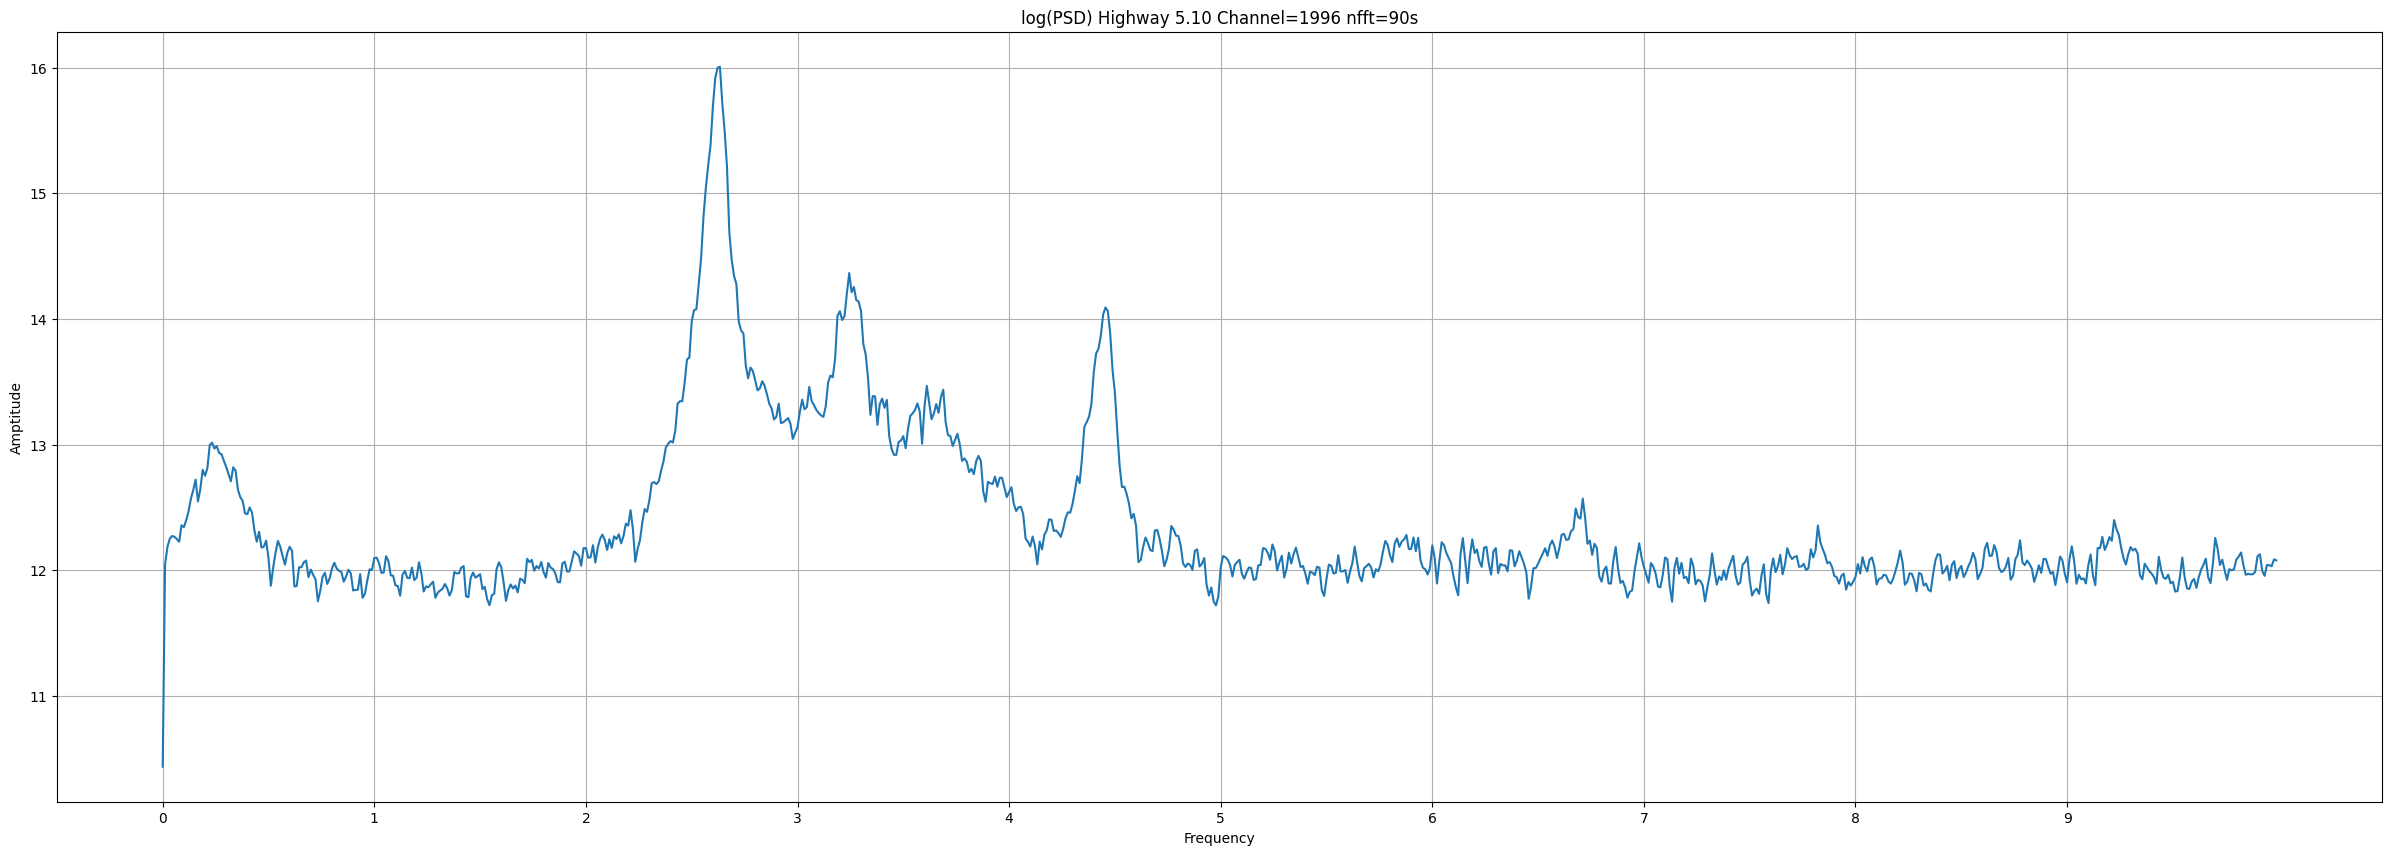

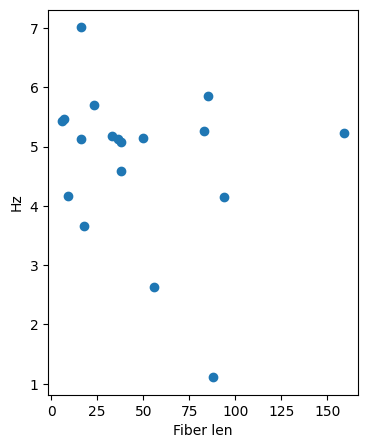

[88, 16, 7, 83, 38, 6, 18, 85, 23, 36, 50, 94, 33, 9, 159, 16, 38, 56] [1.1111111111111112, 5.122222222222222, 5.466666666666667, 5.266666666666667, 5.0777777777777775, 5.4222222222222225, 3.6666666666666665, 5.844444444444444, 5.7, 5.133333333333334, 5.144444444444445, 4.155555555555556, 5.177777777777778, 4.166666666666667, 5.233333333333333, 7.011111111111111, 4.588888888888889, 2.6333333333333333]


In [4]:
import h5py 
import numpy as np
import matplotlib.pyplot as plt
import os
path = '/mnt/f/Highway_2024_0510/output/psd_5_31/'
if not os.path.exists(path):
    os.makedirs(path)

mutation_stamp = [ 43, 131,  390,406, 427, 434,   470,     553, 587,    625,  679,  685,  745, 763, 770, 855, 865, 888, 930, 966, 1009,
                  1059, 1157, 1251,  1310, 1343,  1381, 1390, 1411, 1570, 1788, 1804, 1860, 1898, 1968, 2024]

ch_list =[ (mutation_stamp[i]+mutation_stamp[i+1])//2 for i in range(0,len(mutation_stamp) , 2)]

max_fre = []
print(ch_list)
for ch in ch_list:
    psd = []
    all_time = []
    for fi in range(1,2):
        with h5py.File('/mnt/f/Highway_2024_0510/output/psd_5_31/test03_05_10_'+str(fi)+'.hdf5', 'r') as f:
            # print(f.keys())
            if len(f[str(ch)].keys()) == 1 :
                dset = f[str(ch)]['01']
            else:
                dset = f[str(ch)]
            time = [key for key in dset.keys()]
            # print(time)
            # start = time.index('20:00:12')
            # time = time[start:]+time[:start]
            # print(time)

            psd.append(  [dset[key][:] for key in time])
            all_time.append(time[:])
            f.close()
    print("-----------read",ch,"------------")
    
    print(len(psd))
    print(len(all_time))
    psd = np.concatenate(psd)
    time = np.concatenate(all_time)
    print(psd.shape)
    print(len(time))
    psd = np.log(np.sum(psd,axis=0))
    print(psd.shape)

    psd = psd[:45001// 50]
    print(psd.shape)
    max_fre.append(np.argmax(psd)/90)
    plt.figure(figsize=(30,10))
    plt.plot(psd)
    # plt.imshow(psd.T, aspect='auto', cmap='viridis')
    plt.grid(alpha = 1)
    xstick = [90*i for i in range(10)]
    # print(f['frequency'].shape)
    # plt.xticks(xstick , [time[i][:2]+" "+time[i][3:]  for i in xstick],rotation = 0)
    plt.xticks(xstick , ['%d'% (i/90.)  for i in xstick])
    plt.xlabel("Frequency")
    plt.ylabel("Amptitude")
    plt.title("log(PSD) Highway 5.10 Channel="+str(ch)+" nfft=90s")
    # plt.savefig(path+'/test03_ch_'+str(ch)+'_psd.png') #10s per pic
    plt.show()

    plt.close()

bridge_len = [ ( -mutation_stamp[i]+mutation_stamp[i+1]) for i in range(0,len(mutation_stamp) , 2)]
plt.figure(figsize=[4,5])
plt.plot(bridge_len,max_fre,'o')
plt.ylabel("Hz")
plt.xlabel("Fiber len")
plt.show()

print(bridge_len , max_fre)


with h5py.File('/mnt/f/Highway_2024_0510/output/psd_5_20_v0/test03_05_10_'+str(fi)+'.hdf5', 'r') as f:
plt.title("log(mean(PSD))  Highway 5.10  space="+str(chi_list[0]*8) + "-" + str(chi_list[-1]*8) +"m  nfft=30000")
path = '/mnt/f/Highway_2024_0510/output/psd_5_20_v1/'


-----------read 130 ------------
88
(1848, 45001)
21
(45001,)
-----------read 389 ------------
259
(5439, 45001)
21
(45001,)
-----------read 405 ------------
16
(336, 45001)
21
(45001,)
-----------read 426 ------------
21
(441, 45001)
21
(45001,)
-----------read 433 ------------
7
(147, 45001)
21
(45001,)
-----------read 469 ------------
36
(756, 45001)
21
(45001,)
-----------read 552 ------------
83
(1743, 45001)
21
(45001,)
-----------read 586 ------------
34
(714, 45001)
21
(45001,)
-----------read 624 ------------
38
(798, 45001)
21
(45001,)
-----------read 678 ------------
54
(1134, 45001)
21
(45001,)
-----------read 684 ------------
6
(126, 45001)
21
(45001,)
-----------read 744 ------------
60
(1260, 45001)
21
(45001,)
-----------read 762 ------------
18
(378, 45001)
21
(45001,)
-----------read 769 ------------
7
(147, 45001)
21
(45001,)
-----------read 854 ------------
85
(1785, 45001)
21
(45001,)
-----------read 864 ------------
10
(210, 45001)
21
(45001,)
-----------read 887 

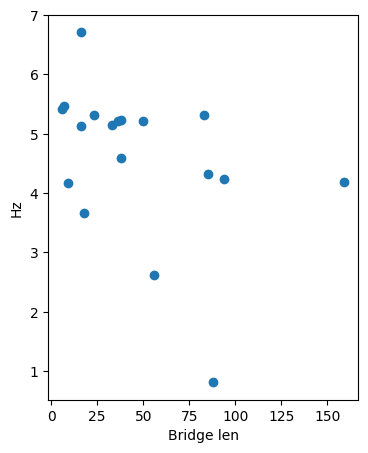

[0.8111111111111111, 0.8222222222222222, 5.122222222222222, 5.455555555555556, 5.466666666666667, 6.555555555555555, 5.322222222222222, 1.3888888888888888, 5.233333333333333, 5.366666666666666, 5.4222222222222225, 3.6666666666666665, 3.6666666666666665, 3.6666666666666665, 4.322222222222222, 2.4555555555555557, 5.311111111111111, 2.7222222222222223, 5.211111111111111, 5.677777777777778, 5.222222222222222, 1.1, 4.233333333333333, 9.6, 5.144444444444445, 3.1333333333333333, 4.166666666666667, 6.322222222222222, 4.188888888888889, 5.911111111111111, 6.711111111111111, 0.022222222222222223, 4.588888888888889, 2.966666666666667, 2.6222222222222222]


In [19]:
import h5py 
import numpy as np
import matplotlib.pyplot as plt

path = '/mnt/f/Highway_2024_0510/output/psd_5_31/'
if not os.path.exists(path):
    os.makedirs(path)

mutation_stamp = [ 43, 131,  390,406, 427, 434,   470,     553, 587,    625,  679,  685,  745, 763, 770, 855, 865, 888, 930, 966, 1009,
                  1059, 1157, 1251,  1310, 1343,  1381, 1390, 1411, 1570, 1788, 1804, 1860, 1898, 1968, 2024]
max_fre = []
for i in range(0 , len(mutation_stamp) -1  , 1):
    chi_list = range(mutation_stamp[i] , mutation_stamp[i+1])
    psd = []
    for ch in chi_list:
        for fi in range(1,2):
            with h5py.File('/mnt/f/Highway_2024_0510/output/psd_5_31/test03_05_10_'+str(fi)+'.hdf5', 'r') as f:
                # print(f.keys())
                if len(f[str(ch)].keys()) == 1 :
                    dset = f[str(ch)]['01']
                else:
                    dset = f[str(ch)]
                time = [key for key in dset.keys()]
                # print(time)
                # start = time.index('20:00:12')
                # time = time[start:]+time[:start]
                # print(time)

                psd.append(  [dset[key][:] for key in time])
                f.close()
    print("-----------read",ch,"------------")
    
    print(len(psd))
    psd = np.concatenate(psd)
    print(psd.shape)
    print(len(time))
    psd = np.log(np.mean(psd,axis=0))
    print(psd.shape)
    psd = psd[: 45001//50]

    max_fre.append(np.argmax(psd)/90)

    # plt.figure(figsize=(20,10))
    # plt.plot(psd)
    # # plt.imshow(psd.T, aspect='auto', cmap='viridis')
    # plt.grid(alpha = 1)
    # xstick = [90*i for i in range(10)]
    # # print(f['frequency'].shape)
    # # plt.xticks(xstick , [time[i][:2]+" "+time[i][3:]  for i in xstick],rotation = 0)
    # plt.xticks(xstick , ['%d'% (i/90.)  for i in xstick])
    # plt.xlabel("Frequency")
    # plt.ylabel("Amptitude")
    # plt.ylim(0,16)
    # plt.title("log(mean(PSD))  Highway 5.10  space="+str(chi_list[0]*8) + "-" + str(chi_list[-1]*8) +"m  nfft=90s")
    # # plt.savefig(path+ 'test03_avg_'+str(i)+'_psd.png') #10s per pic
    # # plt.show()
    # plt.close()

max_fre
bridge_len = [ ( -mutation_stamp[i]+mutation_stamp[i+1]) for i in range(0,len(mutation_stamp) , 2)]
plt.figure(figsize=[4,5])
plt.plot(bridge_len,max_fre[::2],'o')
plt.ylabel("Hz")
plt.xlabel("Bridge len")
plt.show()
print(max_fre)

6.5 组会建议
1.高速的把光纤长度 换成 桥梁长度，不是桥梁的点减去
2.把频率换成波数
3.城市光纤的自相关画图 0-5s
4.自相关代码用到高速光纤上去，看看结果


In [ ]:
import scipy
from DasTools import DasPrep as dp
def show_ifft_time_range_amtitude_channel(flist  , ch_list, frequencise ,  dis_spacing ,  title ,  save_path  , t_range = [0,-1] , start_time = None , end_time = None ,psdfile = None  ):
    if not os.path.exists(save_path):
        os.makedirs(save_path)
    all_AC = []
    all_psd = []
    # for ch in ch_list:
    #     for fi in flist:
    #         with h5py.File(fi, 'r') as f:
    #             if len(f[str(ch)].keys()) == 1 :
    #                 dset = f[str(ch)]['01']
    #             else:
    #                 dset = f[str(ch)]
    #             time = [i for i in dset.keys()][t_range[0] : t_range[-1]]
                
    #             if start_time is not None and end_time is not None : 
    #                 time = time[time.index(start_time):time.index(end_time)+1]
    #             psd = np.average([dset[ti] for ti in time] ,axis=0)
    #             all_psd.append(psd)
    #             # print(psd.shape)
    #             # plt.figure()
    #             # plt.plot(np.append(psd[::-1][:-2] , psd))
    #             # print(np.append(psd[::-1][:-2] , psd)[15000-3:15000+3])
    #             # plt.show()
    #             AC = np.fft.ifft( np.abs(np.append(psd[::-1][:-2] , psd)))
    #             # AC2 = np.fft.ifft( np.abs( psd))


    #             # # avg_AC = np.average([np.fft.ifft( np.abs(np.append(np.array(dset[ti])[::-1][:-2] , dset[ti]))) for ti in time] ,axis=0)
    #             # plt.figure()
    #             # plt.plot(AC)
    #             # plt.plot(avg_AC)
    #             # plt.plot(AC2)
    #             # plt.show()
    #             # print(AC.shape)

    #             f.close()
    #             # AC = np.fft.fftshift(AC)
    #             all_AC.append(np.abs(AC[: len(AC)//2]))

    if psdfile is None:
        with h5py.File(save_path+'acf' +'.hdf5', 'w') as f:
            f.create_dataset(str(time[0] + " - "+time[-1]),  data=all_AC )
            f.close()
    else:
        with h5py.File(psdfile, 'r') as f:
            all_psd = np.array(f['psd'][ch_list[0] : ch_list[1], :])
            print(all_psd.shape)

            # all_psd = np.append(all_psd[::-1 , ] , all_psd ,axis= 1)
            # print(all_psd.shape)
            all_AC = np.abs(np.fft.ifft2(np.append(all_psd[::-1 , ] , all_psd ,axis= 1))[: , : len(all_psd[0])])
            print(all_AC.shape)
    # all_psd = all_psd[80:]
    # all_AC = all_AC[80:]
 
    all_psd= np.array(all_psd)
    all_psd_s= np.log(all_psd)
    
    total_fig = 700

    plt.figure(figsize=(30, 35 ))
    time_stick = [np.linspace(0,len(all_AC[0]) , 4) ,np.around( np.linspace(0, len(all_AC[0])/frequencise , 4 ) , 1) ]
    ch_stick = [range(0,len(all_psd),50) , range(ch_list[0], ch_list[1],50)]


    plt.subplot(total_fig+11)
    clim = all_psd_s.std() /30
    plt.imshow(all_psd_s.T, aspect='auto', cmap='jet', vmin=0, vmax=12)
    plt.yticks( np.linspace(0,len(all_psd[0]),11) ,np.linspace(0,frequencise//2,11))
    plt.xticks(ch_stick[0],ch_stick[1])
    plt.ylabel("fq(Hz)")
    plt.xlabel("Channel")
    plt.grid()
    plt.title("log(PSD)"+title + time[0] + " - "+time[-1])
    plt.colorbar()


    sum_psd = np.sum(all_psd,axis = 1)
    plt.subplot(total_fig+12)
    plt.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.3, hspace=0.3)
    plt.plot(sum_psd)
    plt.ylabel("amplitude")
    plt.xlabel("Channel")
    plt.xticks(ch_stick[0],ch_stick[1])
    plt.grid()
    plt.title("sum(PSD)"+title + time[0] + " - "+time[-1])

    balenced_psd =  np.divide(all_psd.T,sum_psd /70000)
    balenced_psd_s = np.log(balenced_psd)

    plt.subplot(total_fig+13)
    clim = balenced_psd.std() 
    print(clim ,all_psd.std()) 
    plt.imshow(balenced_psd_s, aspect='auto', cmap='jet', vmin=0, vmax=6)
    plt.yticks( np.linspace(0,len(all_psd[0]),11) ,np.linspace(0,frequencise//2,11))
    plt.ylabel("fq(Hz)")
    plt.xticks(ch_stick[0],ch_stick[1])
    plt.xlabel("Channel")
    plt.grid()
    plt.title("balence (PSD)"+title + time[0] + " - "+time[-1])
    plt.colorbar()

    all_AC= np.array(all_AC)
    all_AC = np.divide(all_AC.T , sum_psd /70000 ).T
    all_AC_s= all_AC /np.max(all_AC)
    plt.subplot(total_fig+14)
    clim = all_AC_s.std() /20
    plt.imshow(all_AC_s.T, aspect='auto', cmap='jet', vmin=0, vmax=clim)
    plt.yticks(time_stick[0] , time_stick[1])
    plt.ylabel("Time(s)")
    plt.xticks(ch_stick[0],ch_stick[1])
    plt.xlabel("Channel")
    plt.grid()
    plt.title("ifft(PSD)"+title + time[0] + " - "+time[-1])
    plt.colorbar()


    w = 13
    rolling_mean = np.array ([ np.convolve(ac, np.ones(w), "valid") / w for ac in all_AC] )
    rolling_mean_s = rolling_mean / np.max(rolling_mean)
    plt.subplot(total_fig+15)
    clim = rolling_mean_s.std() /20
    plt.imshow(rolling_mean_s.T, aspect='auto', cmap='jet', vmin=0, vmax=clim)
    plt.yticks(time_stick[0] , time_stick[1])
    plt.ylabel("Time(s)")
    plt.xlabel("Channel")
    plt.grid()
    plt.xticks(ch_stick[0],ch_stick[1])

    plt.title(" moving window average (ifft(PSD) , w = "+str(w)+" )"+title + time[0] + " - "+time[-1])
    plt.colorbar()


    deco = np.array([scipy.signal.deconvolve(all_AC[i] , rolling_mean[i])[1] for i in range(len(all_AC))])
    print(deco.shape)
    deco_s = deco/np.max(deco)
    plt.subplot(total_fig+16)
    clim = deco_s.std() /30
    plt.imshow(deco_s.T, aspect='auto', cmap='gray', vmin=0, vmax=clim)
    plt.yticks(time_stick[0] , time_stick[1])
    plt.ylabel("Time(s)")
    plt.xlabel("Channel")
    plt.grid()
    plt.xticks(ch_stick[0],ch_stick[1])

    plt.title(" decon(rolliong(ifft(PSD))) "+title + time[0] + " - "+time[-1])
    plt.colorbar()

    filter_data = dp.bandpass(deco, 0.001, 1 , 30 )
    filter_data_s = filter_data/np.max(filter_data)
    plt.subplot(total_fig+17)
    clim = filter_data_s.std()/20
    plt.imshow(filter_data_s.T, aspect='auto', cmap='gray', vmin=0, vmax=clim)
    plt.yticks(time_stick[0] , time_stick[1])
    plt.xticks(ch_stick[0],ch_stick[1])

    plt.ylabel("Time(s)")
    plt.xlabel("Channel")
    plt.grid()

    plt.title("1-30 filter decon(rolliong(ifft(PSD))) "+title + time[0] + " - "+time[-1])
    plt.colorbar()
    plt.savefig(save_path+time[0]+"-"+time[-1]+" 1-30 filter,ch "+str(ch_list), bbox_inches="tight")
    plt.show()
    plt.close()



show_ifft_time_range_amtitude_channel(psdfile='/mnt/f/Highway_2024_0510/output/psd_5_11_v3/test03_05_10_all_psd.hdf5', flist=[] , ch_list = [450,750] , frequencise= 1000 , dis_spacing= 8 , title='high way   ' , save_path='/mnt/f/Highway_2024_0510/output/psd_5_11_v3/')


(2040, 3001)
(2040, 6002)
73.34113438883729 89863.38


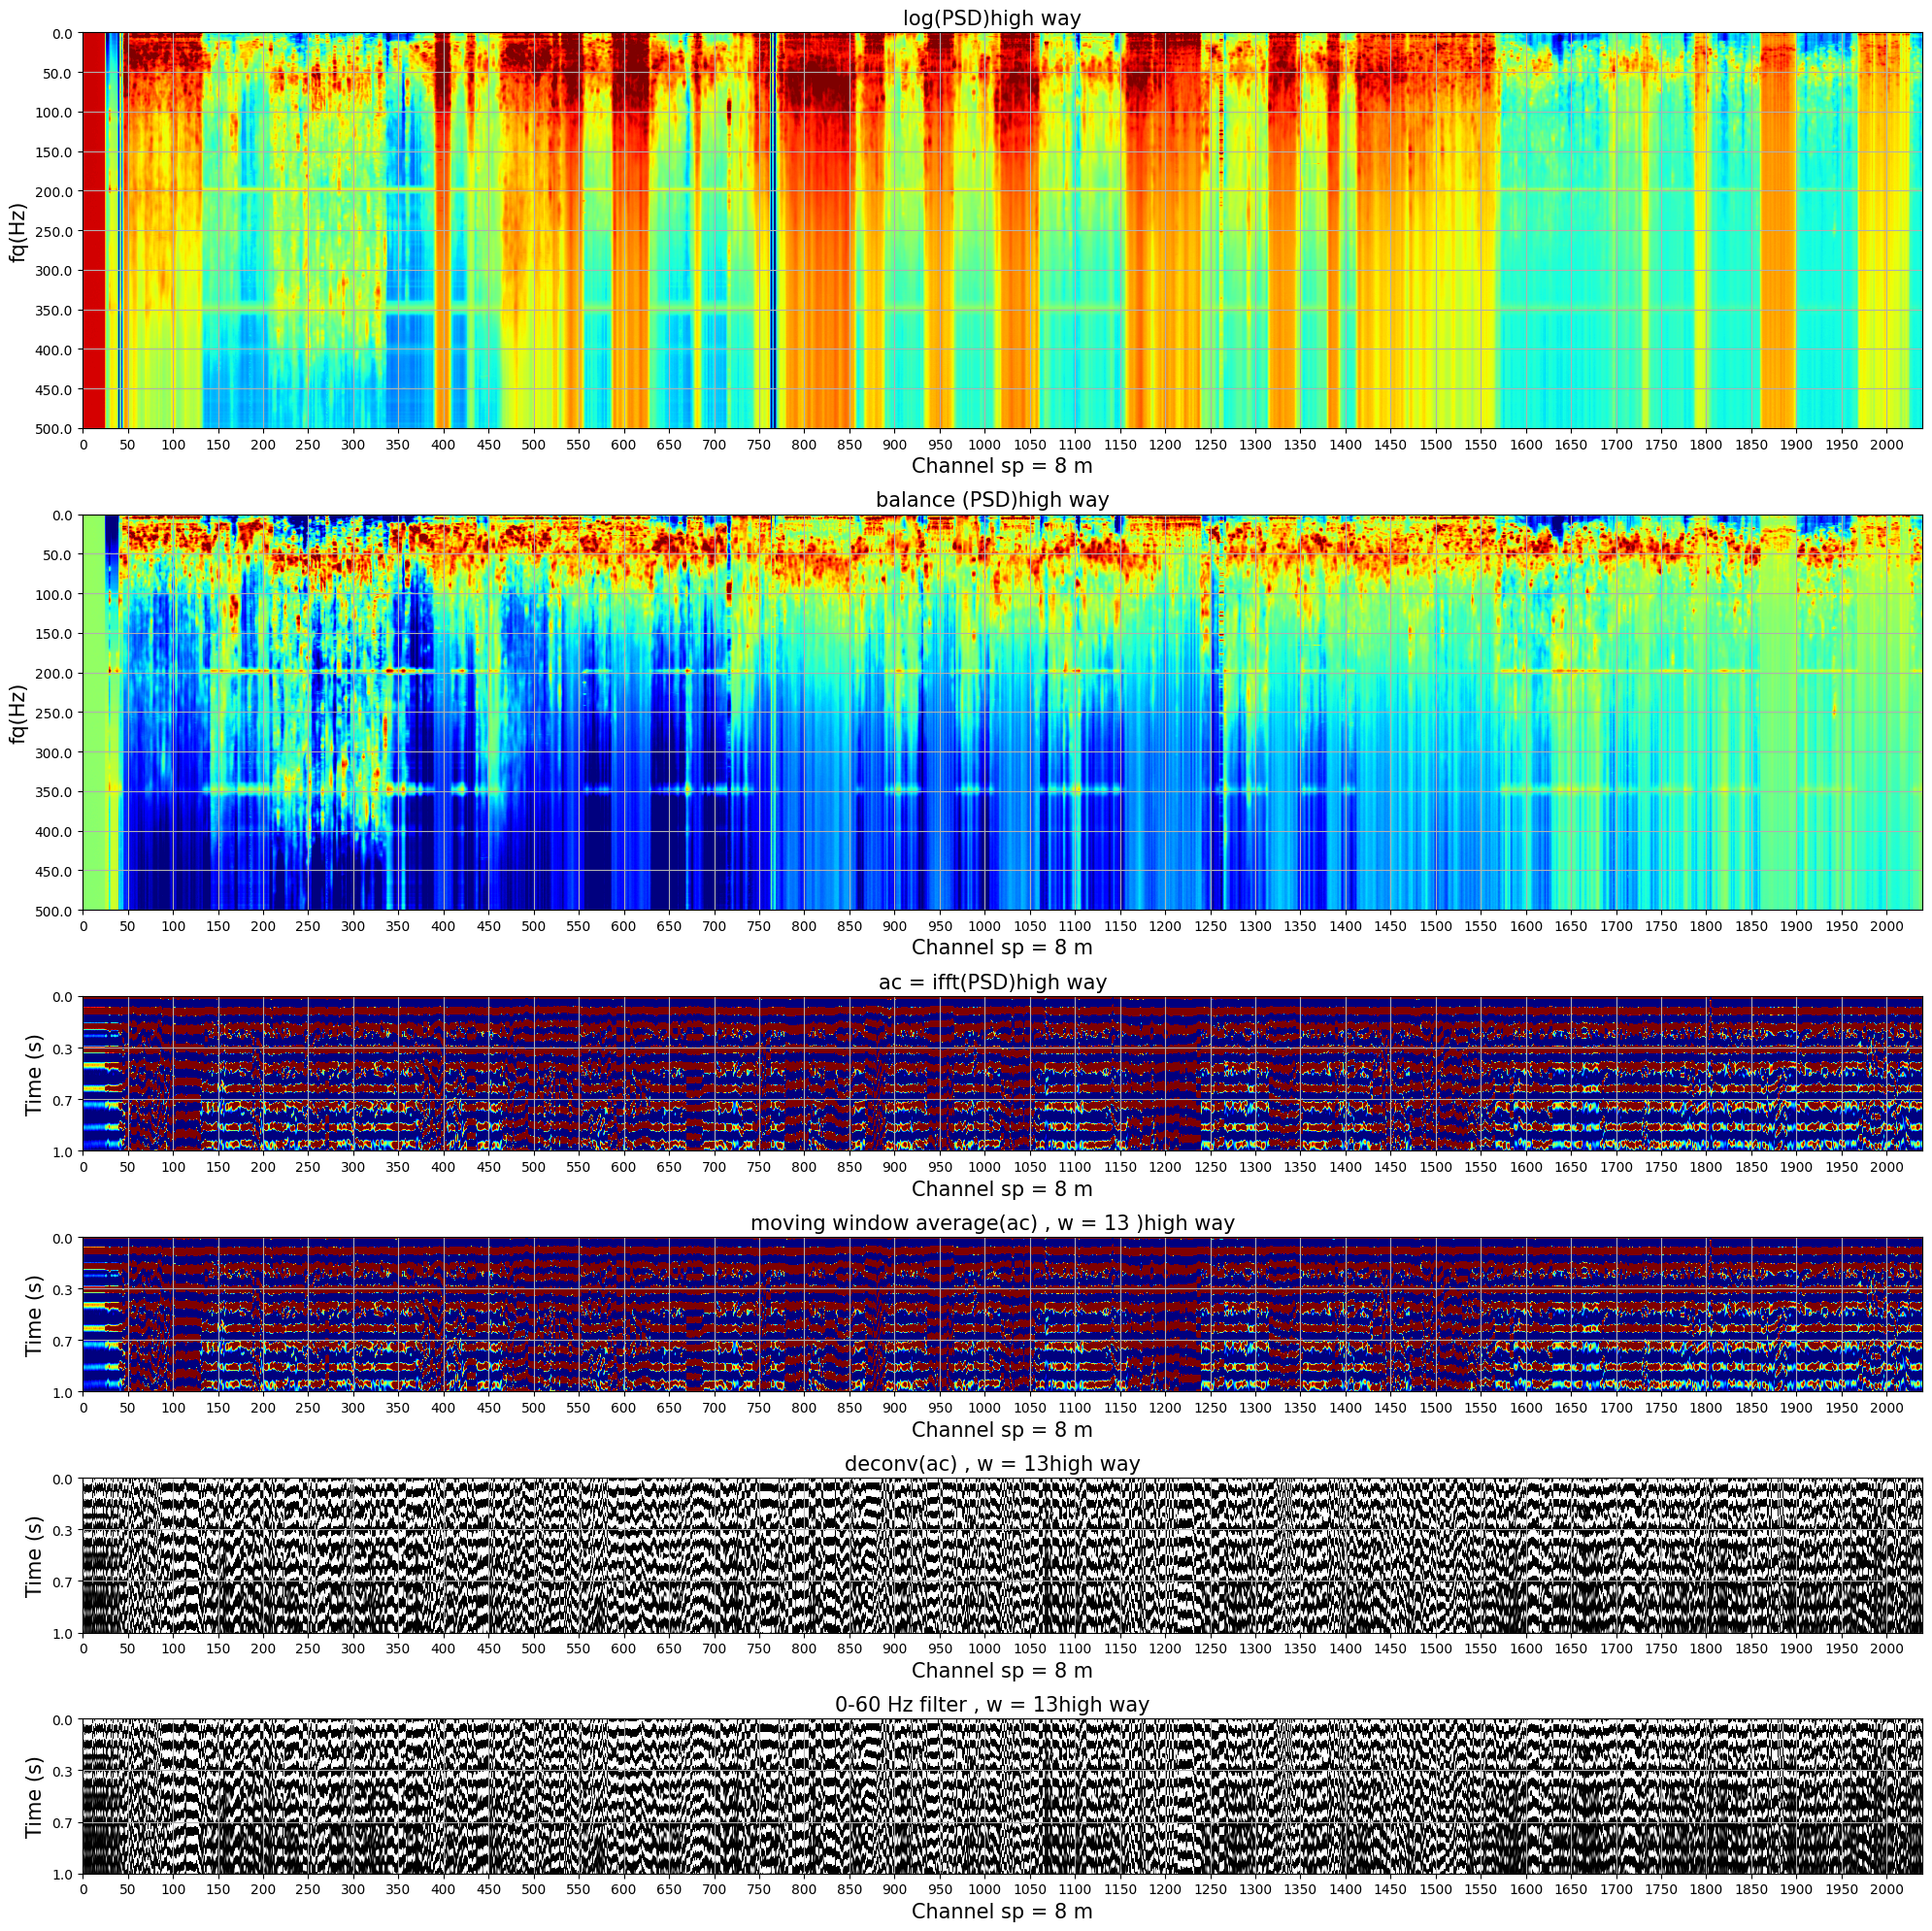

In [18]:

import scipy
from DasTools import DasPrep as dp

def plot_sub_set(ax  , xsticks = [] , ysticks = []  , xlabel = '', ylabel = '', title = ''):
    fonts = 15
    ax.set_yticks(ysticks[0],ysticks[1])
    ax.set_xticks(xsticks[0],xsticks[1])
    ax.set_ylabel(ylabel,fontsize=fonts)
    ax.set_xlabel(xlabel,fontsize=fonts)
    ax.grid()
    ax.set_title(title,fontsize=fonts)
    ax.tick_params(axis='x', labelsize=fonts-5)
    ax.tick_params(axis='y', labelsize=fonts-5)



def show_ifft_time_range_amtitude_channel(flist  , ch_list, frequencise ,  dis_spacing ,  title ,  save_path  , t_range = [0,-1] , start_time = None , end_time = None ,psdfile = None  ):
    if not os.path.exists(save_path):
        os.makedirs(save_path)
    all_AC = []
    all_psd = []
    if psdfile is None:
        for ch in ch_list:
            for fi in flist:
                with h5py.File(fi, 'r') as f:
                    if len(f[str(ch)].keys()) == 1 :
                        dset = f[str(ch)]['01']
                    else:
                        dset = f[str(ch)]
                    time = [i for i in dset.keys()][t_range[0] : t_range[-1]]
                    
                    if start_time is not None and end_time is not None : 
                        time = time[time.index(start_time):time.index(end_time)+1]
                    psd = np.average([dset[ti] for ti in time] ,axis=0)
                    all_psd.append(psd)
                    AC = np.fft.ifft( np.abs(np.append(psd[::-1][:-2] , psd)))
                    f.close()
                    # AC = np.fft.fftshift(AC)
                    all_AC.append(np.abs(AC[: len(AC)//2]))


        with h5py.File(save_path+'acf' +'.hdf5', 'w') as f:
            f.create_dataset(str(time),  data=all_AC )
            f.close()
    else:
        with h5py.File(psdfile, 'r') as f:
            all_psd = np.array(f['psd'][ch_list[0] : ch_list[1], :])
            print(all_psd.shape)
            all_AC =np.array([ np.fft.fftshift( np.abs(np.fft.ifft(np.append(all_psdi[::-1] , all_psdi))) )for all_psdi in all_psd])
            time = ""
            print(all_AC.shape)

    sum_psd = np.sum(all_psd,axis = 1)    
    balenced_psd =  np.divide(all_psd.T,sum_psd /70000)
    print(balenced_psd.std() ,all_psd.std()) 
    all_AC = np.divide(all_AC.T , sum_psd /70000 ).T
    w = 200
    rolling_mean = np.array ([ np.convolve(ac, np.ones(w), "valid") / w for ac in all_AC] )
    deco = np.array([scipy.signal.deconvolve(all_AC[i] , rolling_mean[i])[1] for i in range(len(all_AC))])
    filter_data = dp.bandpass(deco, 0.001, 8 , 12 )
    # filter_data = dp.lowpass(deco, 0.001, 60 )



    all_AC_s= all_AC [:,3000:4000]/np.max(all_AC) * 20

    plt.figure(figsize=(20, 20 ))
    fq_stick = [ np.linspace(0,len(all_psd[0]),11) ,np.linspace(0,frequencise//2,11) ]
    time_stick = [np.linspace(0,len(all_AC_s[0]) , 4) ,np.around( np.linspace(0, len(all_AC_s[0])/frequencise , 4 ) , 1) ]
    ch_stick = [range(0,len(all_psd),50) , range(ch_list[0], ch_list[1],50)]
    ax_list = []
    ax_list.append(plt.subplot2grid((8, 1), (0, 0), rowspan=2))
    ax_list.append(plt.subplot2grid((8, 1), (2, 0), rowspan=2))
    ax_list.append(plt.subplot2grid((8, 1), (4, 0), rowspan=1))
    ax_list.append(plt.subplot2grid((8, 1), (5, 0), rowspan=1))  
    ax_list.append(plt.subplot2grid((8, 1), (6, 0), rowspan=1))
    ax_list.append(plt.subplot2grid((8, 1), (7, 0), rowspan=1))


    ax_list[0].imshow(np.log(all_psd).T, aspect='auto', cmap='jet', vmin=0, vmax=12)
    plot_sub_set(ax_list[0] , ch_stick , fq_stick , 'Channel sp = 8 m' , 'fq(Hz)' , "log(PSD)"+title + time)
    
    ax_list[1].imshow(np.log(balenced_psd), aspect='auto', cmap='jet', vmin=0, vmax=6)
    plot_sub_set(ax_list[1] , ch_stick , fq_stick , 'Channel sp = 8 m' , 'fq(Hz)' , "balance (PSD)"+title + time)


    all_AC_s= dp.bandpass(all_AC, 0.001, 8 , 12 )[:,3000:4000]
    ax_list[2].imshow(all_AC_s.T, aspect='auto', cmap='jet', vmin=0, vmax= all_AC_s.std() /20)
    plot_sub_set(ax_list[2] , ch_stick , time_stick , 'Channel sp = 8 m' , 'Time (s)' , "ac = ifft(PSD)"+title + time)

    rolling_mean_s =dp.bandpass( rolling_mean, 0.001, 8 , 12 ) [:,3000:4000]
    ax_list[3].imshow(rolling_mean_s.T, aspect='auto', cmap='jet', vmin=0, vmax=rolling_mean_s.std() /20)
    plot_sub_set(ax_list[3] , ch_stick , time_stick , 'Channel sp = 8 m' , 'Time (s)' , "moving window average(ac) , w = "+str(w)+" )"+title + time)

    deco_s = dp.bandpass( deco, 0.001, 8 , 12 )[:,3000:4000]
    ax_list[4].imshow(deco_s.T, aspect='auto', cmap='gray', vmin=0, vmax=deco_s.std() /30)
    plot_sub_set(ax_list[4] , ch_stick , time_stick , 'Channel sp = 8 m' , 'Time (s)' , "deconv(ac) , w = "+str(w)+title + time)

    filter_data_s = filter_data[:,3000:4000]
    ax_list[5].imshow(filter_data_s.T, aspect='auto', cmap='gray', vmin=0, vmax=filter_data_s.std()/20)
    plot_sub_set(ax_list[5] , ch_stick , time_stick , 'Channel sp = 8 m' , 'Time (s)' , "0-60 Hz filter , w = "+str(w)+title + time)
    plt.tight_layout() 
    plt.savefig(save_path+time+" 10-60 filter,ch "+str(ch_list))
    plt.show()
    plt.close()

show_ifft_time_range_amtitude_channel(psdfile='/mnt/f/Highway_2024_0510/output/psd_5_11_v3/test03_05_10_all_psd.hdf5', flist=[] , ch_list = [0,2040] , frequencise= 1000 , dis_spacing= 8 , title='high way   ' , save_path='/mnt/f/Highway_2024_0510/output/psd_5_11_v3/')



(2176, 3001)
(2176, 6002)
152367.55 87068.4
[5.0, 9.0, 26.0, 2.0, 3.0, 1.0, 4.0, 9.0, 4.0, 4.0, 6.0, 1.0, 6.0, 2.0, 1.0, 9.0, 1.0, 3.0, 5.0, 4.0, 5.0, 5.0, 10.0, 10.0, 6.0, 4.0, 4.0, 1.0, 3.0, 16.0, 22.0, 2.0, 6.0, 4.0, 7.0, 6.0, 16.0] [[0, 43], [43, 131], [131, 390], [390, 406], [406, 427], [427, 434], [434, 470], [470, 553], [553, 587], [587, 625], [625, 679], [679, 685], [685, 745], [745, 761], [761, 770], [770, 855], [855, 865], [865, 888], [888, 930], [930, 966], [966, 1011], [1011, 1059], [1059, 1157], [1157, 1251], [1251, 1310], [1310, 1343], [1343, 1381], [1381, 1390], [1390, 1411], [1411, 1570], [1570, 1788], [1788, 1804], [1804, 1860], [1860, 1898], [1898, 1968], [1968, 2024], [2024, 2175]]


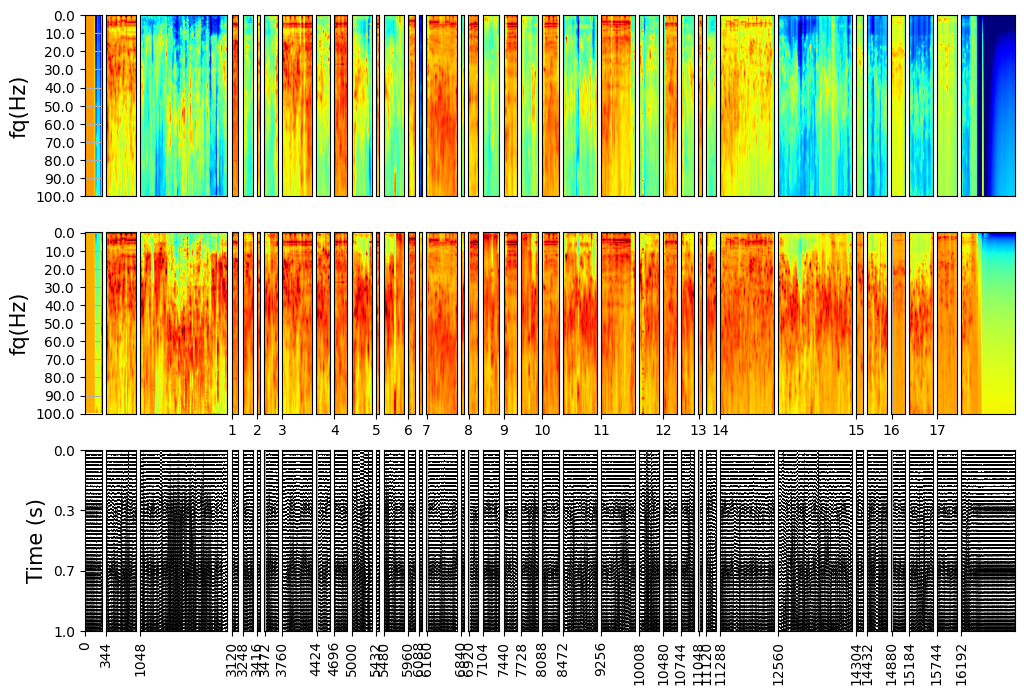

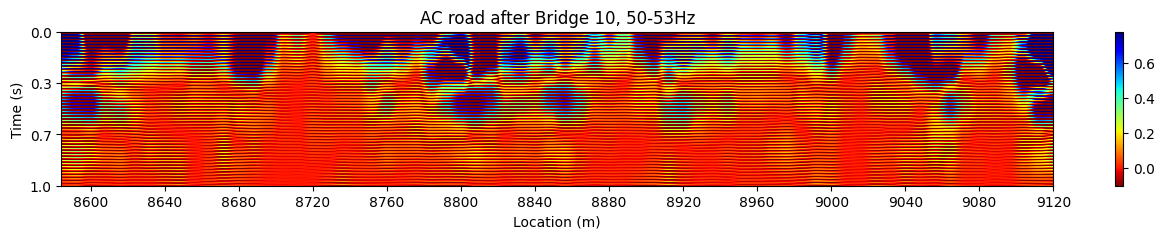

In [40]:
import os
import scipy
from DasTools import DasPrep as dp
import h5py
import glob
from scipy import signal
import numpy as np
import matplotlib.pyplot as plt
import os
import time

##########################################
def plot_sub_set(ax  , xsticks = [] , ysticks = []  , xlabel = '', ylabel = '', title = '', c = -1 , r = 1):
    fonts = 15
    if c > 0 :
        ax.set_yticks([])
    else:
        ax.set_yticks(ysticks[0],ysticks[1])
        ax.set_ylabel(ylabel,fontsize=fonts)
    ax.set_xticks([])
    if r < 0 :
        ax.set_xticks([0],[xsticks[0]*8], rotation=90)
    elif r == 2 and c%2 == 1 and c//2 > 0 :
        ax.set_xticks([0],[c//2])
    # ax.set_xlabel(xlabel,fontsize=fonts)
    ax.grid()
    # ax.set_title(title,fontsize=fonts)
    ax.tick_params(axis='x', labelsize=fonts-5)
    ax.tick_params(axis='y', labelsize=fonts-5)



def show_ifft_time_range_amtitude_channel_split(flist  , ch_list, frequencise ,  dis_spacing ,  title ,  
                                                save_path ,split , t_range = [0,-1] , 
                                                lp = 1 , hp = 200 ,
                                                w = 20,
                                                start_time = None , end_time = None ,psdfile = None  ):
    if not os.path.exists(save_path):
        os.makedirs(save_path)
    all_AC = []
    all_psd = []
    if psdfile is None:
        for ch in ch_list:
            for fi in flist:
                with h5py.File(fi, 'r') as f:
                    if len(f[str(ch)].keys()) == 1 :
                        dset = f[str(ch)]['01']
                    else:
                        dset = f[str(ch)]
                    time = [i for i in dset.keys()][t_range[0] : t_range[-1]]
                    
                    if start_time is not None and end_time is not None : 
                        time = time[time.index(start_time):time.index(end_time)+1]
                    psd = np.average([dset[ti] for ti in time] ,axis=0)
                    all_psd.append(psd)
                    AC = np.fft.ifft( np.abs(np.append(psd[::-1][:-2] , psd)))
                    f.close()
                    # AC = np.fft.fftshift(AC)
                    all_AC.append(np.abs(AC[: len(AC)//2]))


        with h5py.File(save_path+'acf' +'.hdf5', 'w') as f:
            f.create_dataset(str(time),  data=all_AC )
            f.close()
    else:
        with h5py.File(psdfile, 'r') as f:
            all_psd = np.array(f['psd'][ch_list[0] : ch_list[1], :])
            print(all_psd.shape)
            all_AC =np.array([ np.fft.fftshift( np.abs(np.fft.ifft(np.append(all_psdi[::-1] , all_psdi))) )for all_psdi in all_psd])
            time = ""
            print(all_AC.shape)

    sum_psd = np.mean(all_psd,axis = 1)    
    balenced_psd =  np.divide(all_psd.T,sum_psd /50000).T
    print(balenced_psd.std() ,all_psd.std()) 
    all_AC = np.divide(all_AC.T , sum_psd /50000 ).T
    rolling_mean = np.array ([ np.convolve(ac, np.ones(w), "valid") / w for ac in all_AC] )
    deco = np.array([scipy.signal.deconvolve(all_AC[i] , rolling_mean[i])[1] for i in range(len(all_AC))])
    filter_data = dp.bandpass(deco, 0.001, lp , hp )
    # filter_data =deco


    all_psd_s=all_psd[:,:601]
    balenced_psd_s = balenced_psd[:,:601]
    filter_data_s = filter_data[:,3000:4000]/np.max(filter_data) * 20

    title = "w = " + str(w) + " " + str(lp) + "-" + str(hp) + " Hz" + str(len(filter_data_s[0]))
    # filter_data = dp.lowpass(deco, 0.001, 60 )

    fq_stick = [ np.linspace(0,len(all_psd_s[0]),11) ,np.linspace(0,frequencise//10,11) ]
    time_stick = [np.linspace(0,len(filter_data_s[0]) , 4) ,np.around( np.linspace(0, len(filter_data_s[0])/frequencise , 4 ) , 1) ]
    ch_stick = [range(0,len(all_psd),50) , range(ch_list[0], ch_list[1],50)]
    w_r = [ ]
    sp_ch_list= []
    start_ch = 0
    for i in split:
        w_r.append(  np.ceil((i - start_ch)/10))
        sp_ch_list.append([start_ch, i])
        start_ch = i
    
    print(w_r , sp_ch_list)
    fig, ax_list = plt.subplots(3, len(split), gridspec_kw={"width_ratios": w_r, "height_ratios": [1, 1, 1]} , figsize=(12, 8 ))

    
    ax_r1 , ax_r2 , ax_r3 = ax_list
    for c in range(len(split)):
        sp_ch = sp_ch_list[c]
        ax_r1[c].imshow(np.log(all_psd_s[sp_ch[0] : sp_ch[1]]).T, aspect='auto', cmap='jet', vmin=0, vmax=15)
        plot_sub_set(ax_r1[c],sp_ch , fq_stick , 'Channel sp = 8 m' , 'fq(Hz)' , "log(PSD)"+title + time , c)
        ax_r2[c].imshow(np.log(balenced_psd_s[sp_ch[0] : sp_ch[1]]).T, aspect='auto', cmap='jet', vmin=0, vmax=15)
        plot_sub_set(ax_r2[c],sp_ch , fq_stick , 'Channel sp = 8 m' , 'fq(Hz)' , "balance (PSD)"+title + time ,c , r = 2)
        ax_r3[c].imshow(filter_data_s[sp_ch[0] : sp_ch[1]].T, aspect='auto', cmap='gray', vmin=0, vmax=filter_data_s[sp_ch[0] : sp_ch[1]].std()/5)
        plot_sub_set(ax_r3[c],sp_ch , time_stick , 'Channel sp = 8 m' , 'Time (s)' , "10-100 Hz filter , w = "+str(w)+title + time,c , r = -1)
    # plt.tight_layout() 
    # plt.suptitle(title + " PSD -> Balanced -> AC")
    plt.savefig(save_path+time+title+str(ch_list))
    
    plt.show()
    plt.close()

    # for c in [0,1,2,22,30]:
    for c in range(1):
        sp_ch = [1073 , 1141]
        plt.figure(figsize=[16,2])
        plt.imshow(filter_data_s[sp_ch[0] : sp_ch[1]].T, aspect='auto', cmap='jet_r', vmin=0, vmax=filter_data_s[sp_ch[0] : sp_ch[1]].std()/5)
        plt.yticks(time_stick[0] , time_stick[1])
        # if c%2 == 1 and c//2 > 0 :
        #     plt.title("AC Bridge "+ str(c//2))
        # elif c == 2:
        #     plt.title("AC Tunnel")

        # else:
        #     plt.title("AC road after Bridge "+ str(c//2-1))
        plt.title("AC road after Bridge 10, 50-53Hz")

        # plt.xticks([0 , sp_ch[1] - sp_ch[0] - 1 ] , [sp_ch[0]*8 , sp_ch[1]*8])
        plt.xticks([i for i in range(2 , sp_ch[1] - sp_ch[0]  ,5) ] , [i*8 for i in range(sp_ch[0]+2 , sp_ch[1] ,5)])

        plt.ylabel("Time (s)")
        plt.xlabel("Location (m)")
        plt.xlim(0,sp_ch[1] - sp_ch[0] - 1)
        plt.colorbar()

        plt.savefig(save_path+time+title+str(sp_ch))
        plt.show()
        plt.close()
        # plot_sub_set(ax_r3[c],sp_ch , time_stick , 'Channel sp = 8 m' , 'Time (s)' , "10-100 Hz filter , w = "+str(w)+title + time,c , r = -1)



mutation_stamp = [ 43, 131,  390,406, 427, 434,   470,     553, 587,    625,  679,  685,  745, 761, 770, 855, 865, 888, 930, 966, 1011,
                  1059, 1157, 1251,  1310, 1343,  1381, 1390, 1411, 1570, 1788, 1804, 1860, 1898, 1968, 2024 ,2175]
show_ifft_time_range_amtitude_channel_split(psdfile='/mnt/f/Highway_2024_0510/output/psd_5_11_v3/test03_05_10_all_psd.hdf5', 
                                            flist=[] , ch_list = [0,2176] , frequencise= 1000 , dis_spacing= 8 , title='high way   ' , 
                                            split=mutation_stamp,
                                            w = 50 , lp = 50, hp = 53,
                                            save_path='/mnt/f/Highway_2024_0510/output/psd_5_11_v3/')



发现奇怪的信号，画出对应通道的